# Visualizing Geospatial Data in Python

_Reference: https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621_

The following tutorial shows how to use two popular geospatial libraries in Python:

  - [`geopandas`](https://geopandas.org/): extends Pandas to allow spatial operations on geometric types
  - [`geoplot`](https://residentmario.github.io/geoplot/index.html): a high-level geospatial plotting library

## Terminology

Part of the learning curve for working with geospatial data is that there’s lots of special terminology used. Here’s a handy cheat-sheet for terms that you’re likely to encounter:<br>
- shapefile: data file format used to represent items on a map
- geometry: a vector (generally a column in a dataframe) used to represent points, polygons, and other geometric shapes or locations, usually represented as well-known text (WKT)
- polygon: an area
- point: a specific location
- basemap: the background setting for a map, such as county borders in California
- projection: since the Earth is a 3D spheroid, chose a method for how an area gets flattened into 2D map, using some coordinate reference system (CRS)
- colormap: choice of a color palette for rendering data, selected with the cmap parameter
- overplotting: stacking several different plots on top of one another
- choropleth: using different hues to color polygons, as a way to represent data levels
- kernel density estimation: a data smoothing technique (KDE) that creates contours of shading to represent data levels
- cartogram: warping the relative area of polygons to represent data levels
- quantiles: binning data values into a specified number of equal-sized groups
- voronoi diagram: dividing an area into polygons such that each polygon contains exactly one generating point and every point in a given polygon is closer to its generating point than to any other; also called a Dirichlet tessellation

Okay, with those terms defined here for reference … let’s go!

## Get Some Data

We need to get some data to use for these examples. While geoplot includes plenty of sample datasets in the geojson format, it helps to know how to load your own data.

First, let’s get a shapefile from the US Census Bureau TIGER database to visualize state boundaries from this link:

https://www.dl.dropboxusercontent.com/s/9sc7x2lbeknszq3/cb_2018_us_state_20m.zip?dl=0

Next let’s get some data to plot, in this case the 2018 population estimates for the US from this link:

https://www.dl.dropboxusercontent.com/s/qizwv8ai1en416s/nst-est2018-alldata.csv?dl=0

To import the required packages for Python:

In [1]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np

%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

/home/khalifardy/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Then to load a shapefile and view a portion of it:

In [2]:
usa = gpd.read_file("data/cb_2018_us_state_20m.shp")
usa.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...

Notice the `geometry` column above, which specifies *polygon* shapes.

Now we'll load the US Census data as a [`pandas`](https://pandas.pydata.org/) dataframe and view a portion of it:

In [3]:
state_pop = pd.read_csv("data/nst-est2018-alldata.csv")
state_pop.head()

SUMLEV REGION DIVISION  STATE              NAME  CENSUS2010POP  \
0      10      0        0      0     United States      308745538   
1      20      1        0      0  Northeast Region       55317240   
2      20      2        0      0    Midwest Region       66927001   
3      20      3        0      0      South Region      114555744   
4      20      4        0      0       West Region       71945553   

   ESTIMATESBASE2010  POPESTIMATE2010  POPESTIMATE2011  POPESTIMATE2012  \
0          308758105        309326085        311580009        313874218   
1           55318430         55380645         55600532         55776729   
2           66929743         66974749         67152631         67336937   
3          114563045        114867066        116039399        117271075   
4           71946887         72103625         72787447         73489477   

   POPESTIMATE2013  POPESTIMATE2014  POPESTIMATE2015  POPESTIMATE2016  \
0        316057727        318386421        320742673        323071342   
1         55907823         56015864         56047587         56058789   
2         67564135         67752238         67869139         67996917   
3        118393244        119657737        121037542        122401186   
4         74192525         74960582         75788405         76614450   

   POPESTIMATE2017  POPESTIMATE2018  NPOPCHG_2010  NPOPCHG_2011  NPOPCHG_2012  \
0        325147121        327167434        567980       2253924       2294209   
1         56072676         56111079         62215        219887        176197   
2         68156035         68308744         45006        177882        184306   
3        123598424        124753948        304021       1172333       1231676   
4         77319986         77993663        156738        683822        702030   

   NPOPCHG_2013  NPOPCHG_2014  NPOPCHG_2015  NPOPCHG_2016  NPOPCHG_2017  \
0       2183509       2328694       2356252       2328669       2075779   
1        131094        108041         31723         11202         13887   
2        227198        188103        116901        127778        159118   
3       1122169       1264493       1379805       1363644       1197238   
4        703048        768057        827823        826045        705536   

   NPOPCHG_2018  BIRTHS2010  BIRTHS2011  BIRTHS2012  BIRTHS2013  BIRTHS2014  \
0       2020313      987836     3973485     3936976     3940576     3963195   
1         38403      163454      646265      637904      635741      632433   
2        152709      212614      834909      830701      830869      836505   
3       1155524      368752     1509597     1504936     1504799     1525280   
4        673677      243016      982714      963435      969167      968977   

   BIRTHS2015  BIRTHS2016  BIRTHS2017  BIRTHS2018  DEATHS2010  DEATHS2011  \
0     3992376     3962654     3901982     3855500      598691     2512442   
1      634515      628039      616552      609336      110848      470816   
2      837968      831667      816177      804431      140785      586840   
3     1545722     1541342     1519944     1499838      228706      962751   
4      974171      961606      949309      941895      118352      492035   

   DEATHS2012  DEATHS2013  DEATHS2014  DEATHS2015  DEATHS2016  DEATHS2017  \
0     2501531     2608019     2582448     2699826     2703215     2779436   
1      460985      480032      470196      488881      480331      501022   
2      584817      605188      597078      626494      619471      620556   
3      960575     1011093     1006057     1052360     1058173     1092949   
4      495154      511706      509117      532091      545240      564909   

   DEATHS2018  NATURALINC2010  NATURALINC2011  NATURALINC2012  NATURALINC2013  \
0     2814013          389145         1461043         1435445         1332557   
1      506909           52606          175449          176919          155709   
2      621030           71829          248069          245884          225681   
3     1109152          140046      

Next we *merge* the shapefile with population data, joining on the state names:

In [4]:
pop_states = usa.merge(state_pop, left_on="NAME", right_on="NAME")
pop_states.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  SUMLEV REGION DIVISION  \
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...      40      3        5   
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...      40      2        4   
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...      40      3        5   
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...      40      2        3   
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...      40      1        2   

   STATE  CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  POPESTIMATE2011  \
0     24        5773552            5773798          5788642          5838991   
1     19        3046355            3046872          3050767          3066054   
2     10         897934             897934           899595           907316   
3     39       11536504           11536757         11539327         11543463   
4     42       12702379           12702873         12711158         12744583   

   POPESTIMATE2012  POPESTIMATE2013  POPESTIMATE2014  POPESTIMATE2015  \
0          5887072          5923704          5958165          5986717   
1          3076097          3093078          3109504          3121460   
2           915188           923638           932596           941413   
3         11548369         11576576         11602973         11617850   
4         12766827         12776621         12789101         12785759   

   POPESTIMATE2016  POPESTIMATE2017  POPESTIMATE2018  NPOPCHG_2010  \
0          6004692          6024891          6042718         14844   
1          3131785          3143637          3156145          3895   
2           949216           957078           967171          1661   
3         11635003         11664129         11689442          2570   
4         12783538         12790447         12807060          8285   

   NPOPCHG_2011  NPOPCHG_2012  NPOPCHG_2013  NPOPCHG_2014  NPOPCHG_2015  \
0         50349         48081         36632         34461         28552   
1         15287         10043         16981         16426         11956   
2          7721          7872          8450          8958          8817   
3          4136          4906         28207         26397         14877   
4         33425         22244          9794         12480         -3342   

   NPOPCHG_2016  NPOPCHG_2017  NPOPCHG_2018  BIRTHS2010  BIRTHS2011  \
0         17975         20199         17827       18454       73542   
1         10325         11852         12508        9966       37852   
2          7803          7862         10093        2848       11301   
3         17153         29126         25313       34809      137927   
4         -2221          6909         16613       36121      142975   

   BIRTHS2012  BIRTHS2013  BIRTHS2014  BIRTHS2015  BIRTHS2016  BIRTHS2017  \
0       72720       72362       72756       74158       73387       72138   
1       38478       38805       39460       39694       39428       38892   
2       11155       10889       10982       11026       11086       10868   
3      137682      139089      139560      139546      138674      136206   
4      142120      141805      142202      141913      140256      137428   

   BIRTHS2018  DEATHS2010  DEATHS2011  DEATHS2012  DEATHS2013  DEATHS2014  \
0       71029       10628       43674       43461       45736       44735   
1       38417        6871       28210       28048       29139       28925   
2     

Great, now that data is ready to plot a shape. We'll specify `"California"` by name:

<Axes: >

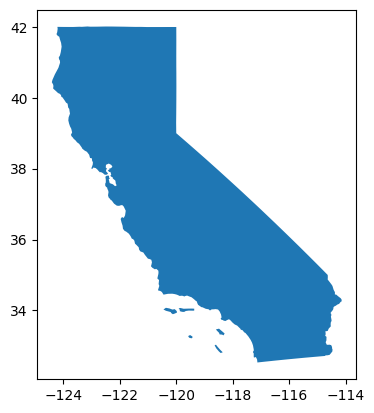

In [18]:
pop_states[pop_states.NAME=="California"].plot()

Alternatively, we can create a *GeoDataFrame* (a dataframe with geospatial data) by loading one of the sample datasets from `geoplot`, in this case the polygones for state boundaries:

In [6]:
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)
contiguous_usa.head()

state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...

Then plot the map of the US states:

<Axes: >

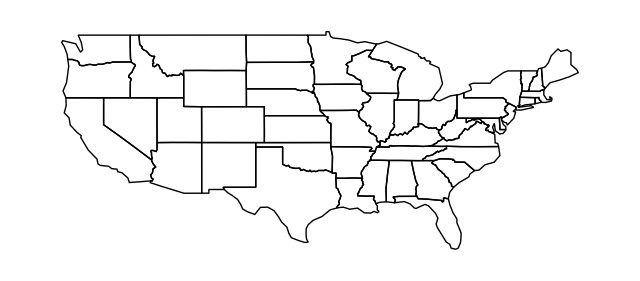

In [7]:
gplt.polyplot(contiguous_usa)

Let's load another sample dataset, in this case for US cities:

In [8]:
path = gplt.datasets.get_path("usa_cities")
usa_cities = gpd.read_file(path)
usa_cities.head()

id  POP_2010  ELEV_IN_FT STATE                     geometry
0   53   40888.0      1611.0    ND  POINT (-101.29627 48.23251)
1  101   52838.0       830.0    ND   POINT (-97.03285 47.92526)
2  153   15427.0      1407.0    ND   POINT (-98.70844 46.91054)
3  177  105549.0       902.0    ND   POINT (-96.78980 46.87719)
4  192   17787.0      2411.0    ND  POINT (-102.78962 46.87918)

Then plot the locations of each city in the continental US as points:

<Axes: >

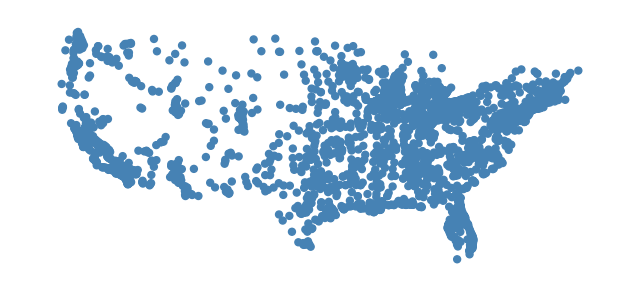

In [9]:
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
gplt.pointplot(continental_usa_cities)

Composing those two, we'll use *overplotting* to show the cities and states in the continental US. Note how the `ax` variable for the state polygons provides an axis on which to plot the cities:

<Axes: >

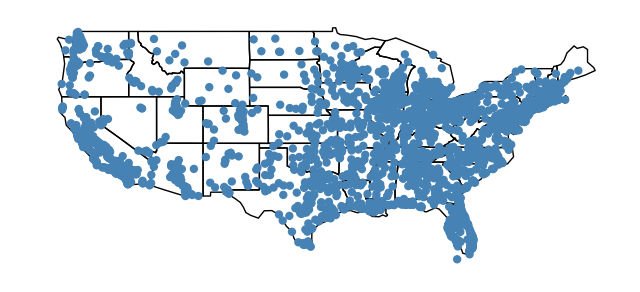

In [10]:
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(continental_usa_cities, ax=ax)

That looks a bit stretched, so let's adjust the *projection* to use an [Albers equal-area conic projection](https://en.wikipedia.org/wiki/Albers_projection):

<GeoAxes: >

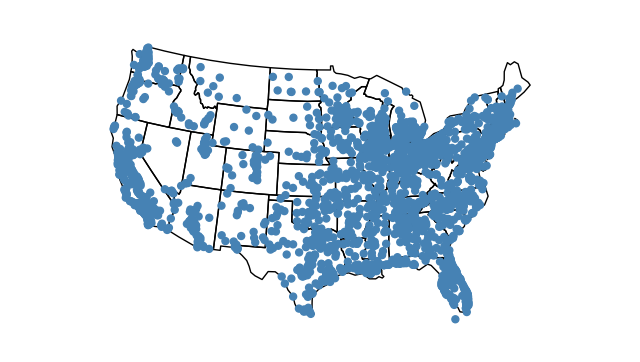

In [11]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())
gplt.pointplot(continental_usa_cities, ax=ax)

## Representing Data

Now let's compare several different ways to visualize geospatial data.
First, we'll change the *hue* of a city's plotted point based on that city's elevation, and also add a *legend* for people to decode the meaning of the different hues.
The parameter lists start to get long-ish, so we'll split each parameter into a different line:

<GeoAxes: >

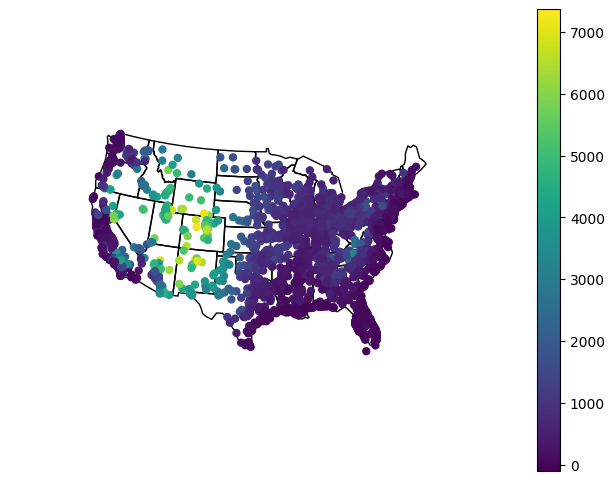

In [12]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.pointplot(
    continental_usa_cities,
    ax=ax,
    hue="ELEV_IN_FT",
    legend=True
)

We can also use the *scale* of each plotted point to represent another dimension. In this case, the scale of the city points is based on their elevation:

Text(0.5, 1.0, 'Cities in the continental US, by elevation')

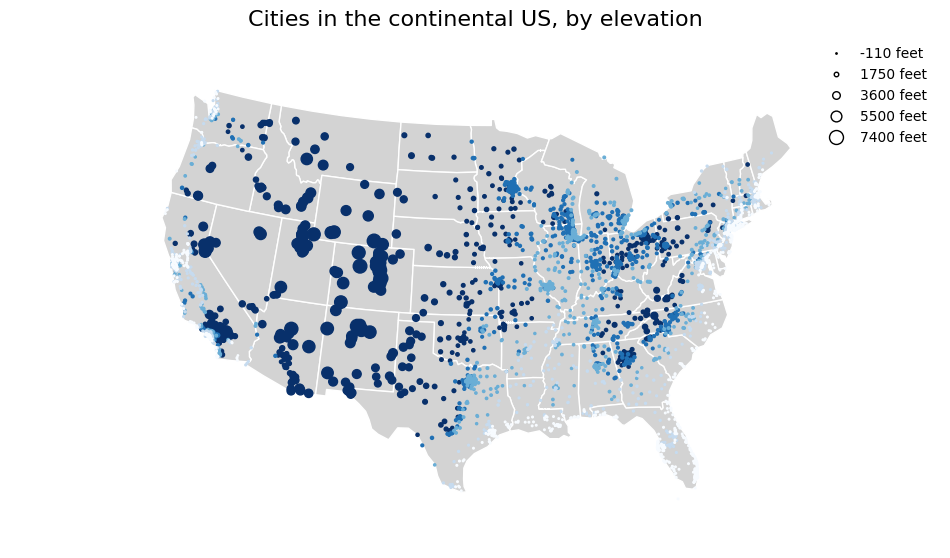

In [13]:
ax = gplt.polyplot(
    contiguous_usa, 
    edgecolor="white",
    facecolor="lightgray",
    figsize=(12, 8),
    projection=gcrs.AlbersEqualArea()
)

gplt.pointplot(
    continental_usa_cities,
    ax=ax,
    hue="ELEV_IN_FT",
    cmap="Blues",
    scheme="quantiles",
    scale="ELEV_IN_FT",
    limits=(1, 10),
    legend=True,
    legend_var="scale",
    legend_kwargs={"frameon": False},
    legend_values=[-110, 1750, 3600, 5500, 7400],
    legend_labels=["-110 feet", "1750 feet", "3600 feet", "5500 feet", "7400 feet"]
)

ax.set_title("Cities in the continental US, by elevation", fontsize=16)

With a *choropleth* we use different hues to shade polygons, to represent a dimension of data:

<GeoAxes: >

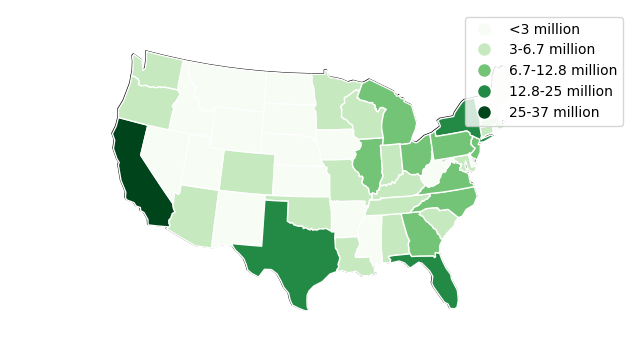

In [14]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.choropleth(
    contiguous_usa,
    hue="population",
    edgecolor="white",
    linewidth=1,
    cmap="Greens",
    legend=True,
    scheme="FisherJenks",
    legend_labels=[
        "<3 million", "3-6.7 million", "6.7-12.8 million",
        "12.8-25 million", "25-37 million"
    ],
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)

A data smoothing technique known as *kernel density estimation* (KDE) creates contours to represent a dimension of data.
In this case, we'll zoom in to view the traffic collisions in the NYC boroughs:

In [15]:
boroughs = gpd.read_file(gplt.datasets.get_path("nyc_boroughs"))
collisions = gpd.read_file(gplt.datasets.get_path("nyc_collision_factors"))

In [16]:
collisions.head()

id  ON STREET NAME  NUMBER OF MOTORIST KILLED  \
0  18  WORTMAN AVENUE                          0   
1  21   HUBERT STREET                          0   
2  69    HENRY STREET                          0   
3  80            None                          0   
4  85  BEDFORD AVENUE                          0   

   CONTRIBUTING FACTOR VEHICLE 3  NUMBER OF CYCLIST INJURED  LONGITUDE  \
0                           None                          0 -73.872007   
1                           None                          0 -74.008344   
2                           None                          0 -73.997563   
3  Failure to Yield Right-of-Way                          0 -73.854542   
4                           None                          0 -73.952731   

      OFF STREET NAME VEHICLE TYPE CODE 4   LATITUDE  \
0                None                None  40.662514   
1                None                None  40.721323   
2                None                None  40.687999   
3  67-64 FLEET STREET                None  40.719228   
4                None                None  40.632147   

                    LOCATION VEHICLE TYPE CODE 1  NUMBER OF MOTORIST INJURED  \
0  (40.6625139, -73.8720068)                TAXI                           0   
1  (40.7213228, -74.0083444)   PASSENGER VEHICLE                           0   
2  (40.6879989, -73.9975625)   PASSENGER VEHICLE                           0   
3  (40.7192276, -73.8545422)   PASSENGER VEHICLE                           0   
4  (40.6321467, -73.9527315)   PASSENGER VEHICLE                           0   

   NUMBER OF PERSONS KILLED CONTRIBUTING FACTOR VEHICLE 4  \
0                         0                          None   
1                         0                          None   
2                         0                          None   
3                         0                          None   
4                         0                          None   

   CONTRIBUTING FACTOR VEHICLE 2  NUMBER OF PEDESTRIANS KILLED  \
0                    Unspecified                             0   
1                           None                             0   
2             Lost Consciousness                             0   
3  Failure to Yield Right-of-Way                             0   
4  Failure to Yield Right-of-Way                             0   

  CROSS STREET NAME  NUMBER OF PERSONS INJURED VEHICLE TYPE CODE 2    BOROUGH  \
0    MONTAUK AVENUE                          0   PASSENGER VEHICLE   BROOKLYN   
1     HUDSON STREET                          1                None  MANHATTAN   
2     WARREN STREET                          0                 VAN   BROOKLYN   
3              None                          0   PASSENGER VEHICLE     QUEENS   
4       CAMPUS ROAD                          0   PASSENGER VEHICLE   BROOKLYN   

   CONTRIBUTING FACTOR VEHICLE 1  ZIP CODE VEHICLE TYPE CODE 3  \
0  Failure to Yield Right-of-Way   11208.0                None   
1  Failure to Yield Right-of-Way   10013.0                None   
2             Lost Consciousness   11201.0                None   
3  Failure to Yield Right-of-Way   11375.0   PASSENGER VEHICLE   
4  Failure to Yield Right-of-Way   11210.0                None   

   NUMBER OF CYCLIST KILLED        DATE  UNIQUE KEY  \
0                         0  11/10/2016     3559576   
1                         0  11/10/2016     3557391   
2                         0  04/16/2016     3419378   
3                         0  04/15/2016     3428072   
4                         0  04/15/2016     3417537   

  CONTRIBUTING FACTOR VEHICLE 5 VEHICLE TYPE CODE 5      TIME  \
0                          None                None  16:11:00   
1                          None                None  05:11:00   
2                          None                None  09:15:00   
3                          None                None  10:20:00   
4                          None                None  10:35:00   

   NUMBER OF PEDESTRIANS INJURED                    geome

/home/khalifardy/anaconda3/lib/python3.11/site-packages/geoplot/geoplot.py:1304: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


AttributeError: 'PlateCarree' object has no attribute 'contains_branch_seperately'

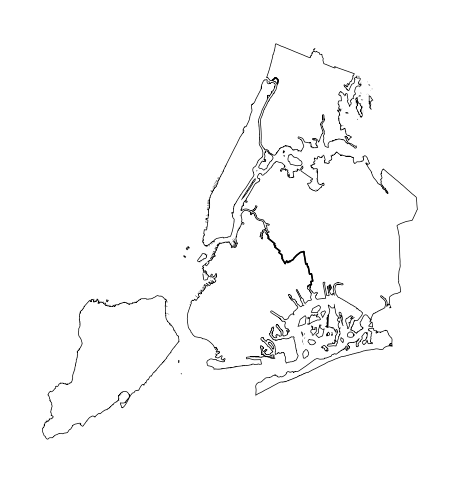

In [17]:
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())
gplt.kdeplot(collisions, cmap="Reds", shade=True, clip=boroughs, ax=ax)

Let's zoom out to try KDE on major population centers throughout the US:

/home/khalifardy/anaconda3/lib/python3.11/site-packages/geoplot/geoplot.py:1304: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


AttributeError: 'PlateCarree' object has no attribute 'contains_branch_seperately'

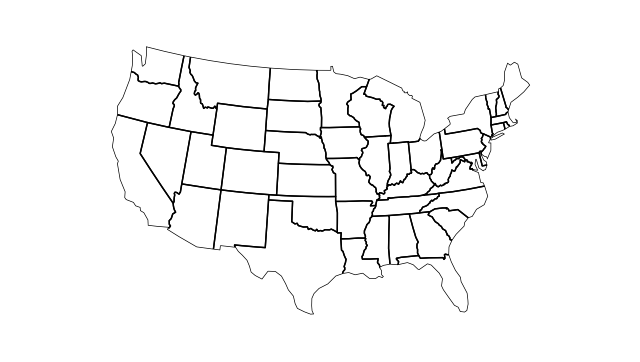

In [ ]:
ax = gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

gplt.kdeplot(
    continental_usa_cities, 
    cmap="Reds", 
    shade=True, 
    clip=contiguous_usa, 
    ax=ax
)

This next section shows how to work with data associated with areas (polygons).
We'll load a dataset about obesity rates by US state:

In [ ]:
obesity = pd.read_csv(gplt.datasets.get_path("obesity_by_state"), sep="\t")
obesity.head()

State  Percent
0   Alabama     32.4
1  Missouri     30.4
2    Alaska     28.4
3   Montana     24.6
4   Arizona     26.8

Convert that into a GeoDataFrame using a *join*.
Note how this adds the required `"geometry"` column:

In [ ]:
geo_obesity = contiguous_usa.set_index("state").join(obesity.set_index("State"))
geo_obesity.head()

adm1_code  population  \
state                                
Minnesota     USA-3514     5303925   
Montana       USA-3515      989415   
North Dakota  USA-3516      672591   
Idaho         USA-3518     1567582   
Washington    USA-3519     6724540   

                                                       geometry  Percent  
state                                                                     
Minnesota     POLYGON ((-89.59941 48.01027, -89.48888 48.013...     25.5  
Montana       POLYGON ((-111.19419 44.56116, -111.29155 44.7...     24.6  
North Dakota  POLYGON ((-96.60136 46.35136, -96.53891 46.199...     31.0  
Idaho         POLYGON ((-111.04973 44.48816, -111.05025 42.0...     29.6  
Washington    POLYGON ((-116.99807 46.33017, -116.90653 46.1...     27.2

Now we can use this data to plot a *cartogram*, which grows or shrinks polygons to represent a dimension of data – in this case, the obesity rates per state:

<GeoAxes: >

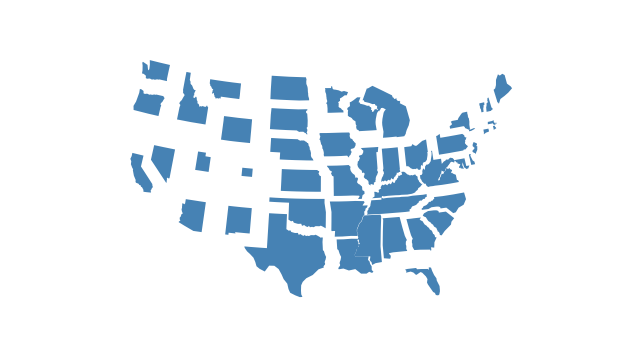

In [ ]:
gplt.cartogram(
    geo_obesity,
    scale="Percent",
    projection=gcrs.AlbersEqualArea()
)

One good approach to simplifying data visualization is binning the data into *quantiles*.
These are equal-sized groups, in this case 10 quantiles for elevation:

In [ ]:
scheme = mc.Quantiles(continental_usa_cities["ELEV_IN_FT"], k=10)
scheme

Quantiles

     Interval        Count
--------------------------
[-112.00,   26.00] |   382
(  26.00,   72.00] |   351
(  72.00,  157.00] |   362
( 157.00,  328.00] |   353
( 328.00,  528.00] |   366
( 528.00,  646.00] |   359
( 646.00,  778.00] |   359
( 778.00,  948.00] |   363
( 948.00, 1310.50] |   359
(1310.50, 7369.00] |   362

Here we've divided the elevations into 10 quantiles with approximately 375 values each.
Now let's assign a different *hue* to each quantile, plus a legend to explain them:

<GeoAxes: >

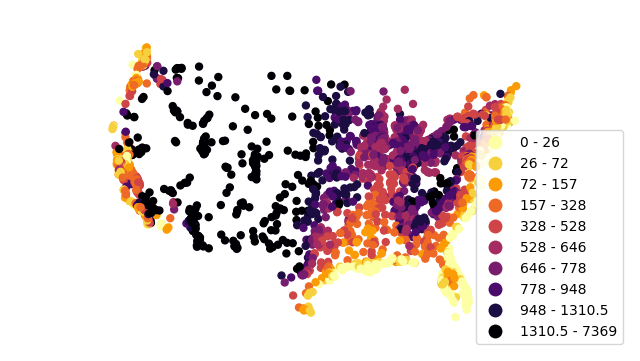

In [ ]:
gplt.pointplot(
    continental_usa_cities,
    projection=gcrs.AlbersEqualArea(),
    hue="ELEV_IN_FT",
    scheme=scheme,
    cmap="inferno_r",
    legend=True
)

Note how the *colormap* was changed to `inferno_r`.
Next, let's add a filter for typical warnings that can be ignored:

In [ ]:
import warnings

warnings.filterwarnings("ignore", "GeoSeries.isna", UserWarning)

The next example uses a *voronoi diagram*, to calculate polygon areas based on a dimension of the data.
Each polygon is centered on a *generating point*, such that every location in the polygon is closer to its generating point than to any other.

In the following example, we'll plot the locations primary schools in Melbourne, Australia, and use a voronoi diagram to show where they are concentrated:

In [ ]:
melbourne = gpd.read_file(gplt.datasets.get_path("melbourne"))
df = gpd.read_file(gplt.datasets.get_path("melbourne_schools"))
melbourne_primary_schools = df.query('School_Type == "Primary"')

/home/khalifardy/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py:5226: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


Text(0.5, 1.0, 'Primary Schools in Greater Melbourne, 2018')

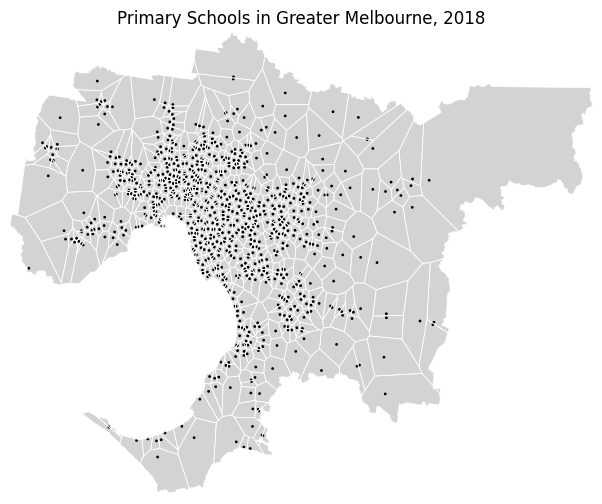

In [ ]:
ax = gplt.voronoi(
    melbourne_primary_schools,
    clip=melbourne,
    linewidth=0.5,
    edgecolor="white",
    projection=gcrs.Mercator()
)

gplt.polyplot(
    melbourne, 
    edgecolor="None", 
    facecolor="lightgray",
    ax=ax
)

gplt.pointplot(
    melbourne_primary_schools,
    color="black",
    ax=ax,
    s=1,
    extent=melbourne.total_bounds
)

plt.title("Primary Schools in Greater Melbourne, 2018")

Let's construct a voronoi diagram for the elevations of US cities.
This is a data smoothing technique since the elevations are for points, but we'll "spread" those values across areas:

In [ ]:
# proj = gplt.crs.AlbersEqualArea(
#     central_longitude=-98,
#     central_latitude=39.5
# )

# ax = gplt.voronoi(
#     continental_usa_cities,
#     hue="ELEV_IN_FT",
#     clip=contiguous_usa,
#     projection=proj,
#     cmap="Reds",
#     legend=True,
#     edgecolor="white",
#     linewidth=0.01
# )

# gplt.polyplot(
#     contiguous_usa,
#     ax=ax,
#     extent=contiguous_usa.total_bounds,
#     edgecolor="black",
#     linewidth=1,
#     zorder=1
# )

## Visualizing COVID-19 Data

Next, we'll visualize some of the COVID-19 data from the University of Washington's [IHME](https://covid19.healthdata.org/united-states-of-america) center.

In [ ]:
ihme = pd.read_csv("data/Hospitalization_all_locs.csv")
ihme.head()

V1 location_name        date  allbed_mean  allbed_lower  allbed_upper  \
0  19692       Abruzzo  2020-02-04          0.0           0.0           0.0   
1  19693       Abruzzo  2020-02-05          0.0           0.0           0.0   
2  19694       Abruzzo  2020-02-06          0.0           0.0           0.0   
3  19695       Abruzzo  2020-02-07          0.0           0.0           0.0   
4  19696       Abruzzo  2020-02-08          0.0           0.0           0.0   

   ICUbed_mean  ICUbed_lower  ICUbed_upper  InvVen_mean  InvVen_lower  \
0          0.0           0.0           0.0          0.0           0.0   
1          0.0           0.0           0.0          0.0           0.0   
2          0.0           0.0           0.0          0.0           0.0   
3          0.0           0.0           0.0          0.0           0.0   
4          0.0           0.0           0.0          0.0           0.0   

   InvVen_upper  deaths_mean  deaths_lower  deaths_upper  admis_mean  \
0           0.0          0.0           0.0           0.0         0.0   
1           0.0          0.0           0.0           0.0         0.0   
2           0.0          0.0           0.0           0.0         0.0   
3           0.0          0.0           0.0           0.0         0.0   
4           0.0          0.0           0.0           0.0         0.0   

   admis_lower  admis_upper  newICU_mean  newICU_lower  newICU_upper  \
0          0.0          0.0          0.0           0.0           0.0   
1          0.0          0.0          0.0           0.0           0.0   
2          0.0          0.0          0.0           0.0           0.0   
3          0.0          0.0          0.0           0.0           0.0   
4          0.0          0.0          0.0           0.0           0.0   

   totdea_mean  totdea_lower  totdea_upper  bedover_mean  bedover_lower  \
0          0.0           0.0           0.0           0.0            0.0   
1          0.0           0.0           0.0           0.0            0.0   
2          0.0           0.0           0.0           0.0            0.0   
3          0.0           0.0           0.0           0.0            0.0   
4          0.0           0.0           0.0           0.0            0.0   

   bedover_upper  icuover_mean  icuover_lower  icuover_upper  \
0            0.0           0.0            0.0            0.0   
1            0.0           0.0            0.0            0.0   
2            0.0           0.0            0.0            0.0   
3            0.0           0.0            0.0            0.0   
4            0.0           0.0            0.0            0.0   

  mobility_data_type  mobility_composite total_tests_data_type  total_tests  \
0                NaN                 NaN                   NaN          NaN   
1                NaN                 NaN                   NaN          NaN   
2                NaN                 NaN                   NaN          NaN   
3                NaN                 NaN                   NaN          NaN   
4                NaN                 NaN                   NaN          NaN   

   confirmed_infections  est_infections_mean  est_infections_lower  \
0                   NaN                  NaN                   NaN   
1                   NaN                  NaN                   NaN   
2                   NaN                  NaN                   NaN   
3                   NaN                  NaN                   NaN   
4                   NaN                  NaN                   NaN   

   est_infections_upper  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

We'll filter rows, limiting this visualization to Earth Day (April 22) 2020:

In [ ]:
is_earthday = ihme["date"]=="2020-04-22"
is_earthday.head()

0    False
1    False
2    False
3    False
4    False
Name: date, dtype: bool

Now merge on state name with the continental US dataset from earlier:

In [ ]:
cv19 = contiguous_usa.merge(ihme[is_earthday], left_on="state", right_on="location_name")
cv19.head()

state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry     V1 location_name  \
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  11447     Minnesota   
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  12056       Montana   
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  13680  North Dakota   
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...   9214         Idaho   
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...  16319    Washington   

         date  allbed_mean  allbed_lower  allbed_upper  ICUbed_mean  \
0  2020-04-22   493.162990    455.458929    529.384375   145.741320   
1  2020-04-22    17.030100     14.048750     20.700000     5.292850   
2  2020-04-22    24.143100     19.650000     29.402500     7.247750   
3  2020-04-22    57.453950     51.097500     64.250000    18.571450   
4  2020-04-22   603.881368    580.271528    627.589861   175.195486   

   ICUbed_lower  ICUbed_upper  InvVen_mean  InvVen_lower  InvVen_upper  \
0    141.332500    150.205714   136.500318    133.354464    140.250000   
1      4.550000      6.101250     4.684750      4.100000      5.400000   
2      6.750000      7.850000     6.814400      6.400000      7.300000   
3     17.000000     20.250000    16.076200     14.850000     17.500000   
4    170.660972    180.125556   155.399446    151.444167    159.490417   

   deaths_mean  deaths_lower  deaths_upper  admis_mean  admis_lower  \
0         17.0          17.0          17.0   76.431872    61.924107   
1          1.0           1.0           1.0    0.000000     0.000000   
2          1.0           1.0           1.0    3.444850     2.000000   
3          2.0           2.0           2.0    4.525300     3.100000   
4         17.0          17.0          17.0   73.325291    65.348889   

   admis_upper  newICU_mean  newICU_lower  newICU_upper  totdea_mean  \
0    91.942647    24.377799     23.000000     26.067500      180.000   
1     0.000000     0.286000      0.050000      0.600000       11.000   
2     5.800000     1.155900      1.000000      1.400000       12.000   
3     6.751250     1.613950      1.250000      2.050000       53.000   
4    81.872778    21.350566     20.144444     22.600556      696.001   

   totdea_lower  totdea_upper  bedover_mean  bedover_lower  bedover_upper  \
0         180.0         180.0           0.0            0.0            0.0   
1          11.0          11.0           0.0            0.0            0.0   
2          12.0          12.0           0.0            0.0            0.0   
3          53.0          53.0           0.0            0.0            0.0   
4         696.0         696.0           0.0            0.0            0.0   

   icuover_mean  icuover_lower  icuover_upper mobility_data_type  \
0           0.0            0.0            0.0           observed   
1           0.0            0.0            0.0           observed   
2           0.0            0.0            0.0           observed   
3           0.0            0.0            0.0           observed   
4           0.0            0.0            0.0           observed   

   mobility_composite total_tests_data_type  total_tests  \
0          -48.426846              observed  1618.603622   
1          -36.893179              observed   264.515854   
2          -34.676742              observed   746.879357   
3          -36.296024              observed   289.599295   
4          -51.945531              observed  2404.474124   

   confirmed_infections  est_infections_mean  est_infections_lower  \
0            170.095721          4794.056933           1905.129415   
1              2.882530            19.781349              9.904035   
2             44.152824            97.421718             42.711405   
3             35.493333            93.011898           

Add a calculated column for "deaths per million":

In [ ]:
deaths_per_mil = cv19["deaths_mean"] / cv19["population"] * 1000000.0
cv19["deaths_per_mil"] = deaths_per_mil
cv19.head()

state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry     V1 location_name  \
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  11447     Minnesota   
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  12056       Montana   
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  13680  North Dakota   
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...   9214         Idaho   
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...  16319    Washington   

         date  allbed_mean  allbed_lower  allbed_upper  ICUbed_mean  \
0  2020-04-22   493.162990    455.458929    529.384375   145.741320   
1  2020-04-22    17.030100     14.048750     20.700000     5.292850   
2  2020-04-22    24.143100     19.650000     29.402500     7.247750   
3  2020-04-22    57.453950     51.097500     64.250000    18.571450   
4  2020-04-22   603.881368    580.271528    627.589861   175.195486   

   ICUbed_lower  ICUbed_upper  InvVen_mean  InvVen_lower  InvVen_upper  \
0    141.332500    150.205714   136.500318    133.354464    140.250000   
1      4.550000      6.101250     4.684750      4.100000      5.400000   
2      6.750000      7.850000     6.814400      6.400000      7.300000   
3     17.000000     20.250000    16.076200     14.850000     17.500000   
4    170.660972    180.125556   155.399446    151.444167    159.490417   

   deaths_mean  deaths_lower  deaths_upper  admis_mean  admis_lower  \
0         17.0          17.0          17.0   76.431872    61.924107   
1          1.0           1.0           1.0    0.000000     0.000000   
2          1.0           1.0           1.0    3.444850     2.000000   
3          2.0           2.0           2.0    4.525300     3.100000   
4         17.0          17.0          17.0   73.325291    65.348889   

   admis_upper  newICU_mean  newICU_lower  newICU_upper  totdea_mean  \
0    91.942647    24.377799     23.000000     26.067500      180.000   
1     0.000000     0.286000      0.050000      0.600000       11.000   
2     5.800000     1.155900      1.000000      1.400000       12.000   
3     6.751250     1.613950      1.250000      2.050000       53.000   
4    81.872778    21.350566     20.144444     22.600556      696.001   

   totdea_lower  totdea_upper  bedover_mean  bedover_lower  bedover_upper  \
0         180.0         180.0           0.0            0.0            0.0   
1          11.0          11.0           0.0            0.0            0.0   
2          12.0          12.0           0.0            0.0            0.0   
3          53.0          53.0           0.0            0.0            0.0   
4         696.0         696.0           0.0            0.0            0.0   

   icuover_mean  icuover_lower  icuover_upper mobility_data_type  \
0           0.0            0.0            0.0           observed   
1           0.0            0.0            0.0           observed   
2           0.0            0.0            0.0           observed   
3           0.0            0.0            0.0           observed   
4           0.0            0.0            0.0           observed   

   mobility_composite total_tests_data_type  total_tests  \
0          -48.426846              observed  1618.603622   
1          -36.893179              observed   264.515854   
2          -34.676742              observed   746.879357   
3          -36.296024              observed   289.599295   
4          -51.945531              observed  2404.474124   

   confirmed_infections  est_infections_mean  est_infections_lower  \
0            170.095721          4794.056933           1905.129415   
1              2.882530            19.781349              9.904035   
2             44.152824            97.421718             42.711405   
3             35.493333            93.011898           

Then to visualize this data, let's plot a choropleth of "deaths per million" per state, and overplot with population per city:

Text(0.5, 1.0, 'COVID-19 deaths/million vs. population, on Earth Day 2020')

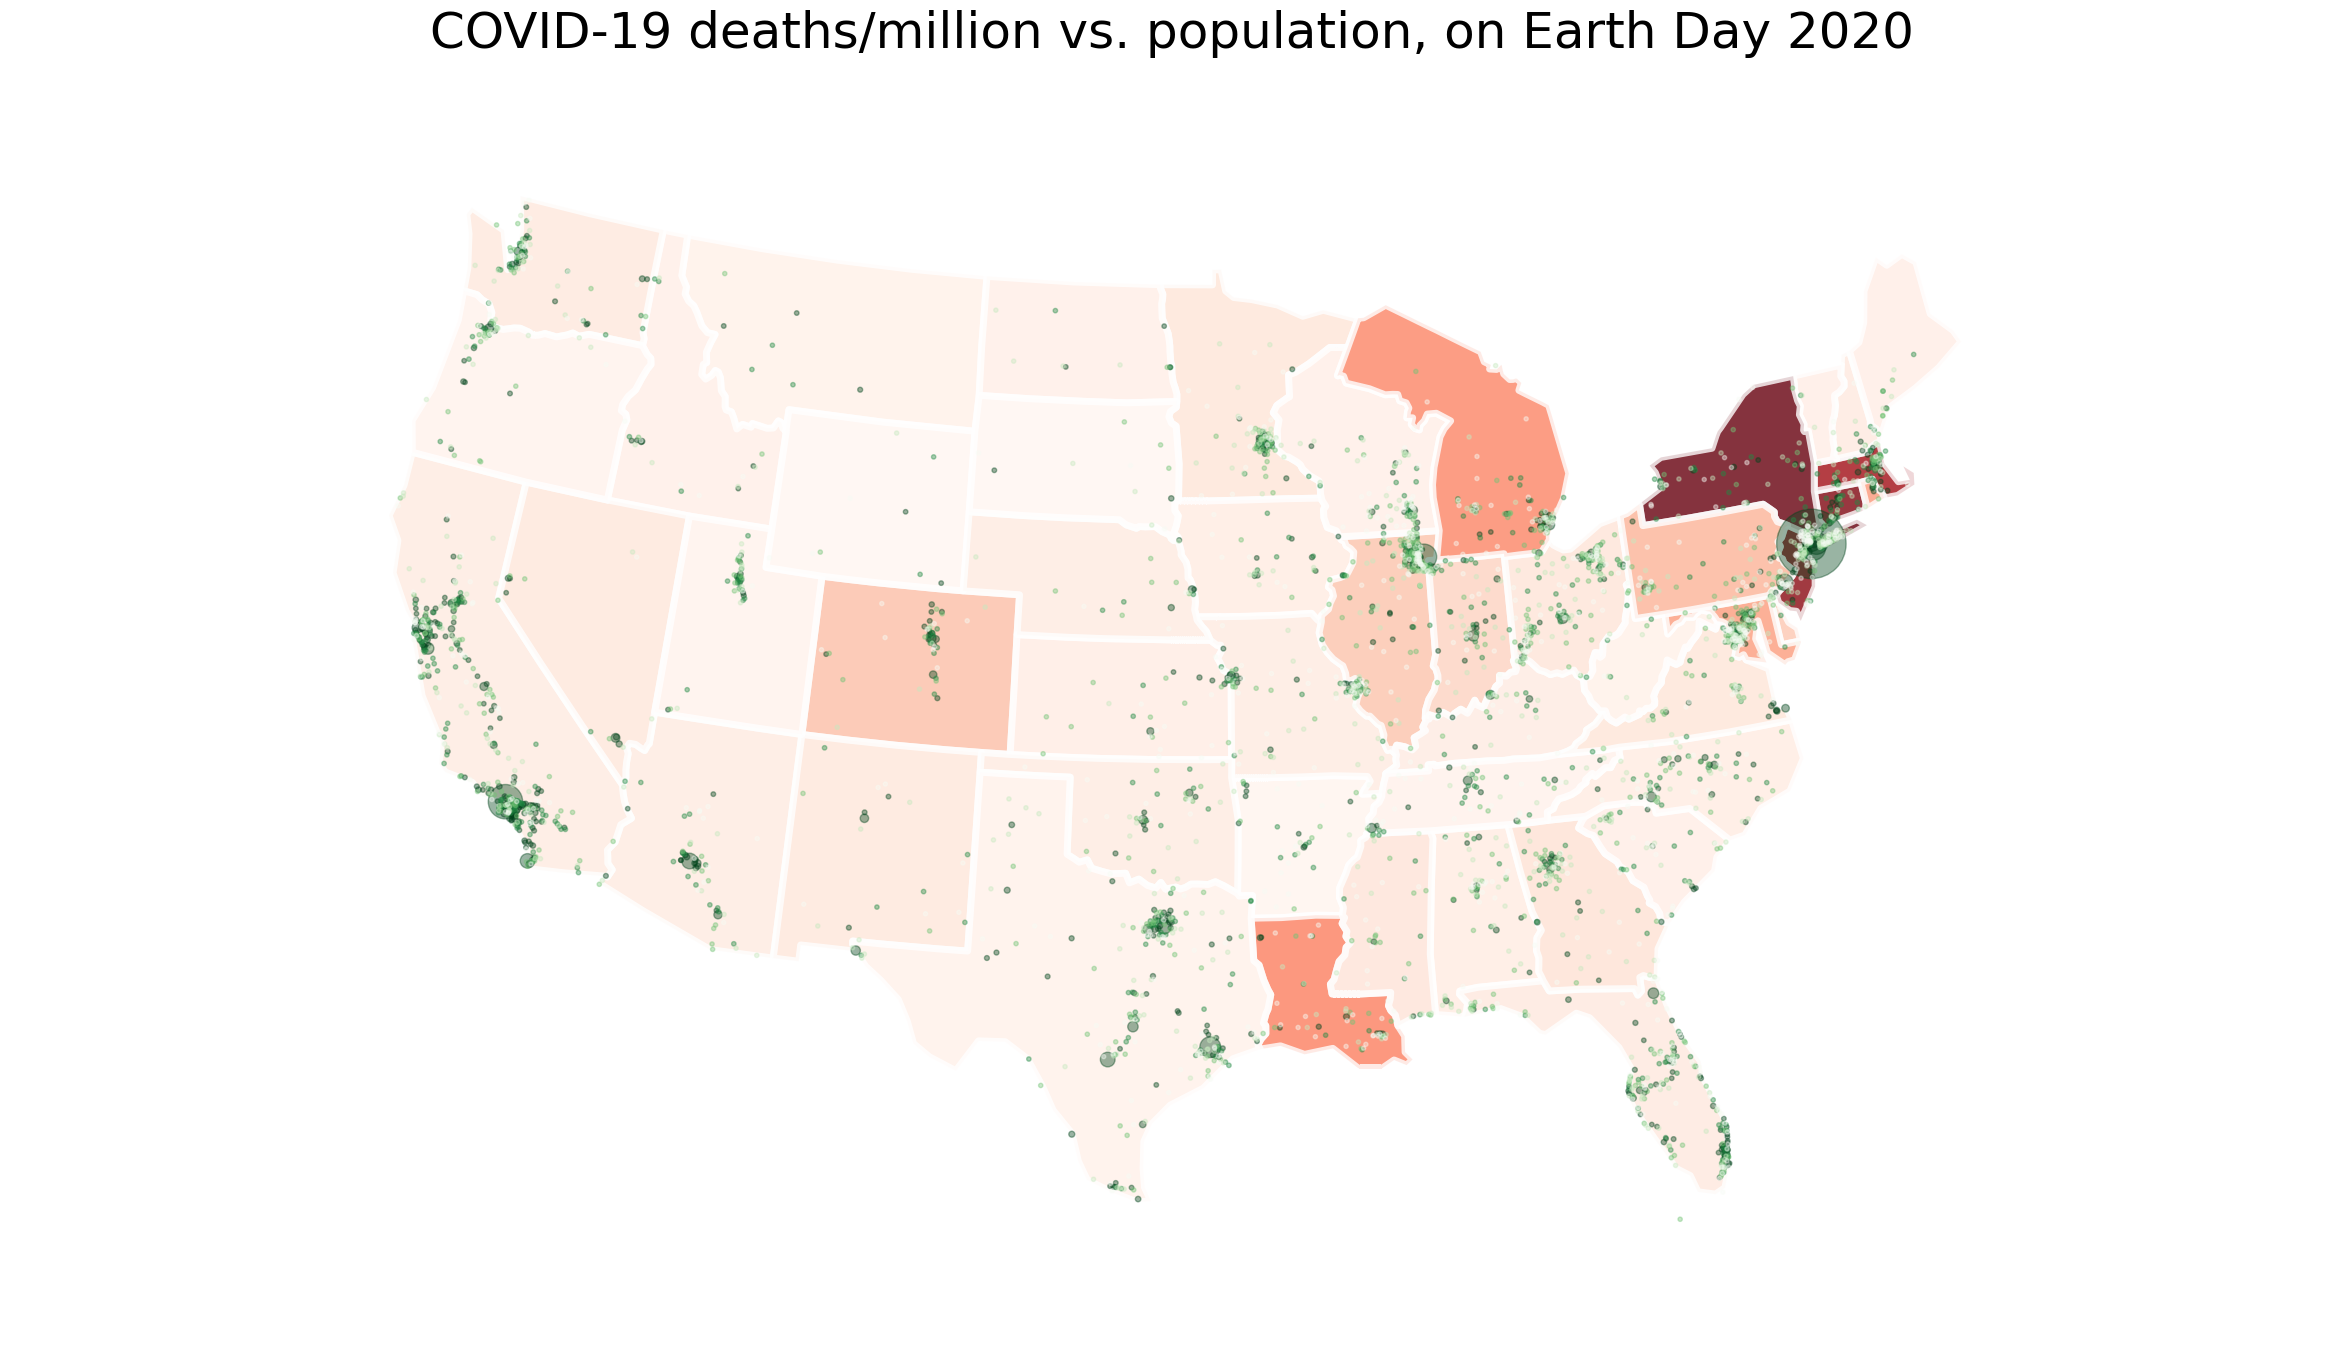

In [ ]:
ax = gplt.choropleth(
    cv19,
    hue="deaths_per_mil",
    edgecolor="white",
    linewidth=5,
    cmap="Reds",
    alpha = 0.8,
    projection=gcrs.AlbersEqualArea(),
    figsize=(30, 30)
)

ax = gplt.pointplot(
    continental_usa_cities,
    hue="POP_2010",
    cmap="Greens",
    scheme="quantiles",
    scale="POP_2010",
    limits=(3, 50),
    zorder=2, 
    alpha = 0.4,
    ax=ax
)

ax.set_title(
    "COVID-19 deaths/million vs. population, on Earth Day 2020",
    fontsize=36
)

Next, let's prepare to animate this visualization. We'll define a function to visualize for a given day:

In [ ]:
def plot_choropleth (anim_path, date, cv19, cities):
    ax = gplt.choropleth(
        cv19,
        hue="deaths_per_mil",
        edgecolor="white",
        linewidth=5,
        cmap="Reds",
        alpha = 0.8,
        projection=gcrs.AlbersEqualArea(),
        figsize=(30, 30)
    )
    
    ax = gplt.pointplot(
        cities,
        hue="POP_2010",
        cmap="Greens",
        scheme="quantiles",
        scale="POP_2010",
        limits=(3, 50),
        zorder=2, 
        alpha = 0.4,
        ax=ax
    )

    ax.set_title(
        f"COVID-19 deaths/million vs. population on {date}",
        fontsize=36
    )

    file_name = str(anim_path / "{}.png".format(date.replace("-", "")))
    plt.savefig(file_name, bbox_inches="tight", pad_inches=0.1)

    return file_name

Define a range of dates:

In [ ]:
date_set = set([])

for d in ihme["date"].tolist():
    if d >= "2020-03-23" and d <= "2020-04-01":
        date_set.add(d)

dates = sorted(list(date_set))

Then iterate through those dates, creating a visualization for each date, which gets saved to a file:

<Figure size 640x480 with 0 Axes>

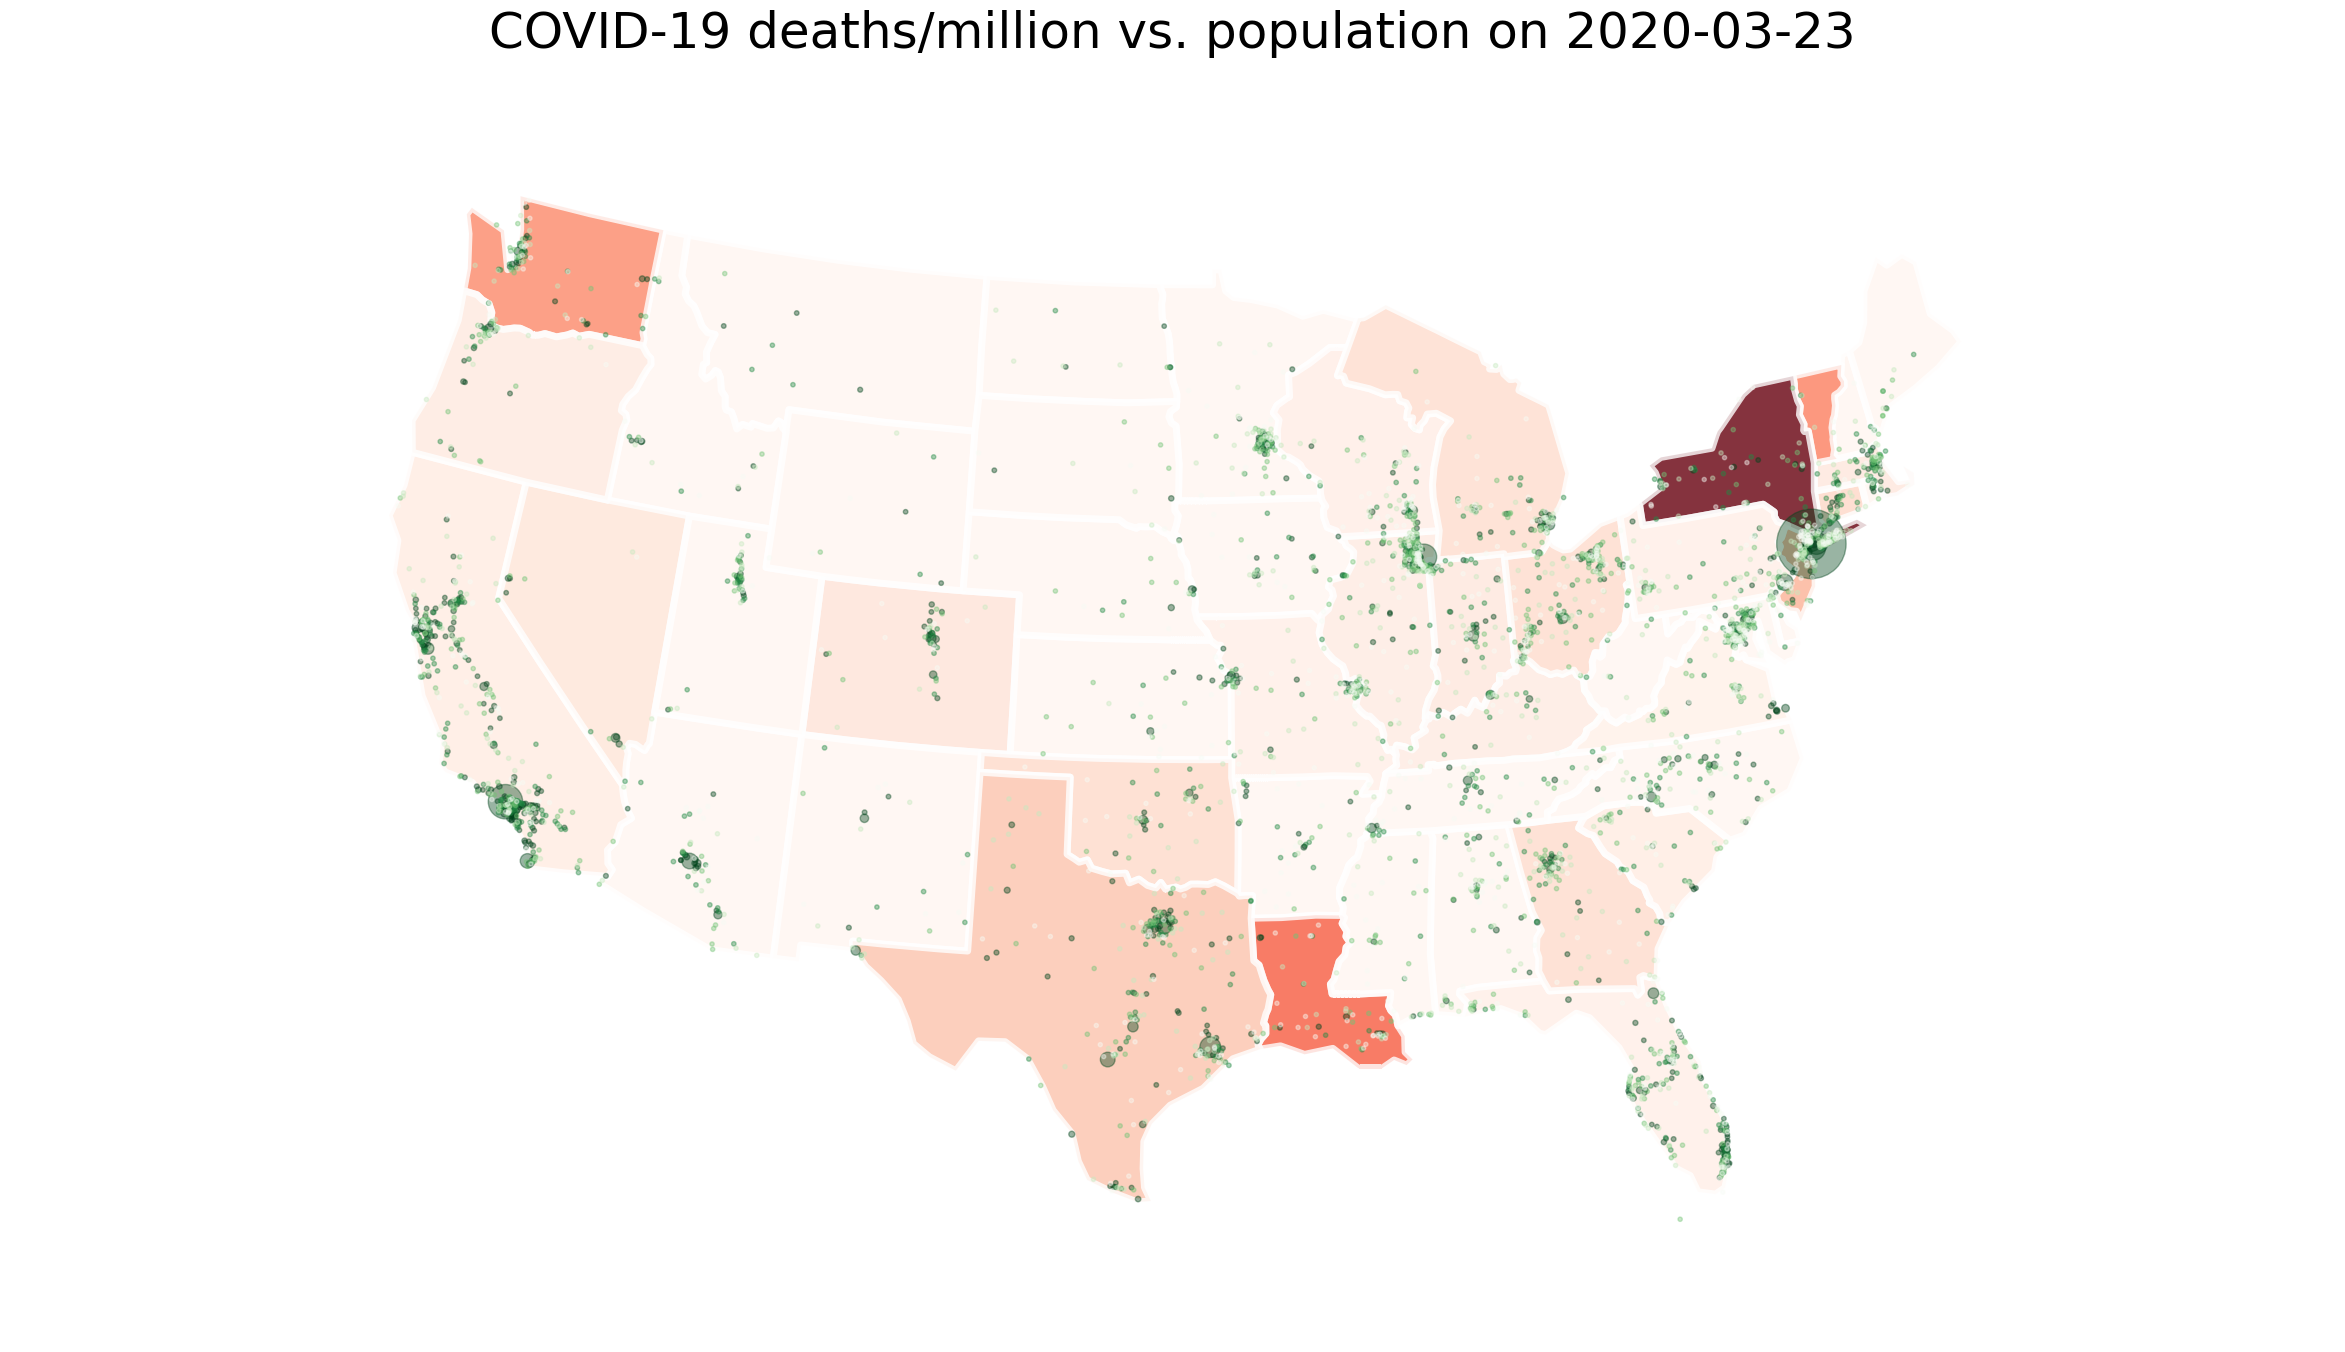

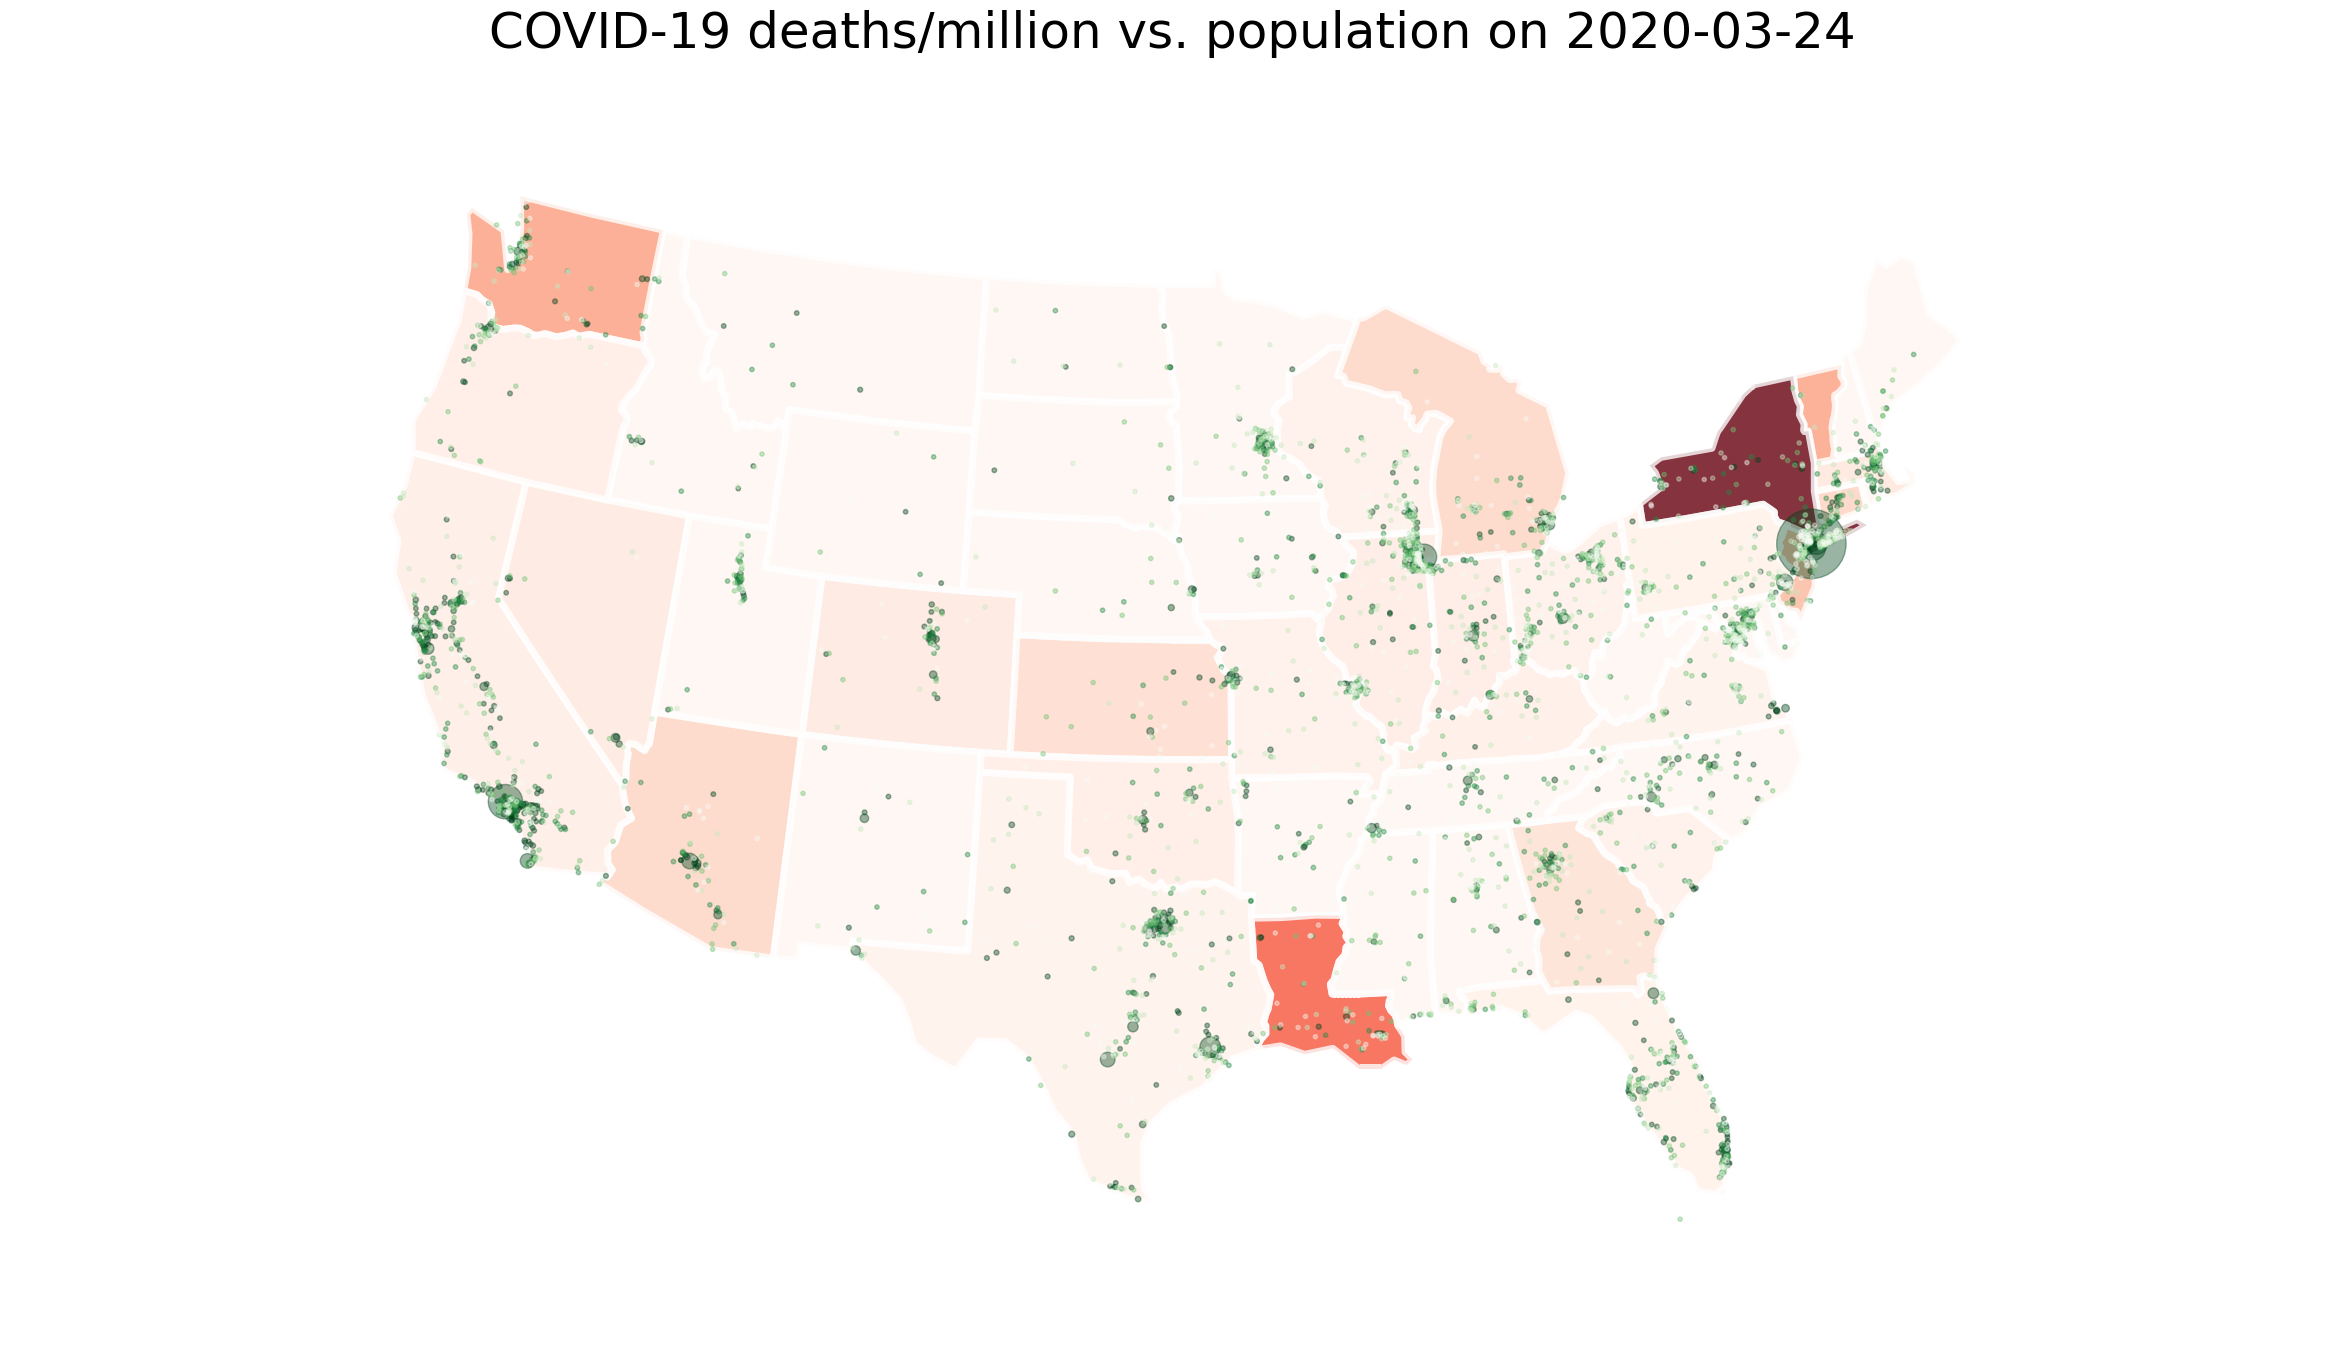

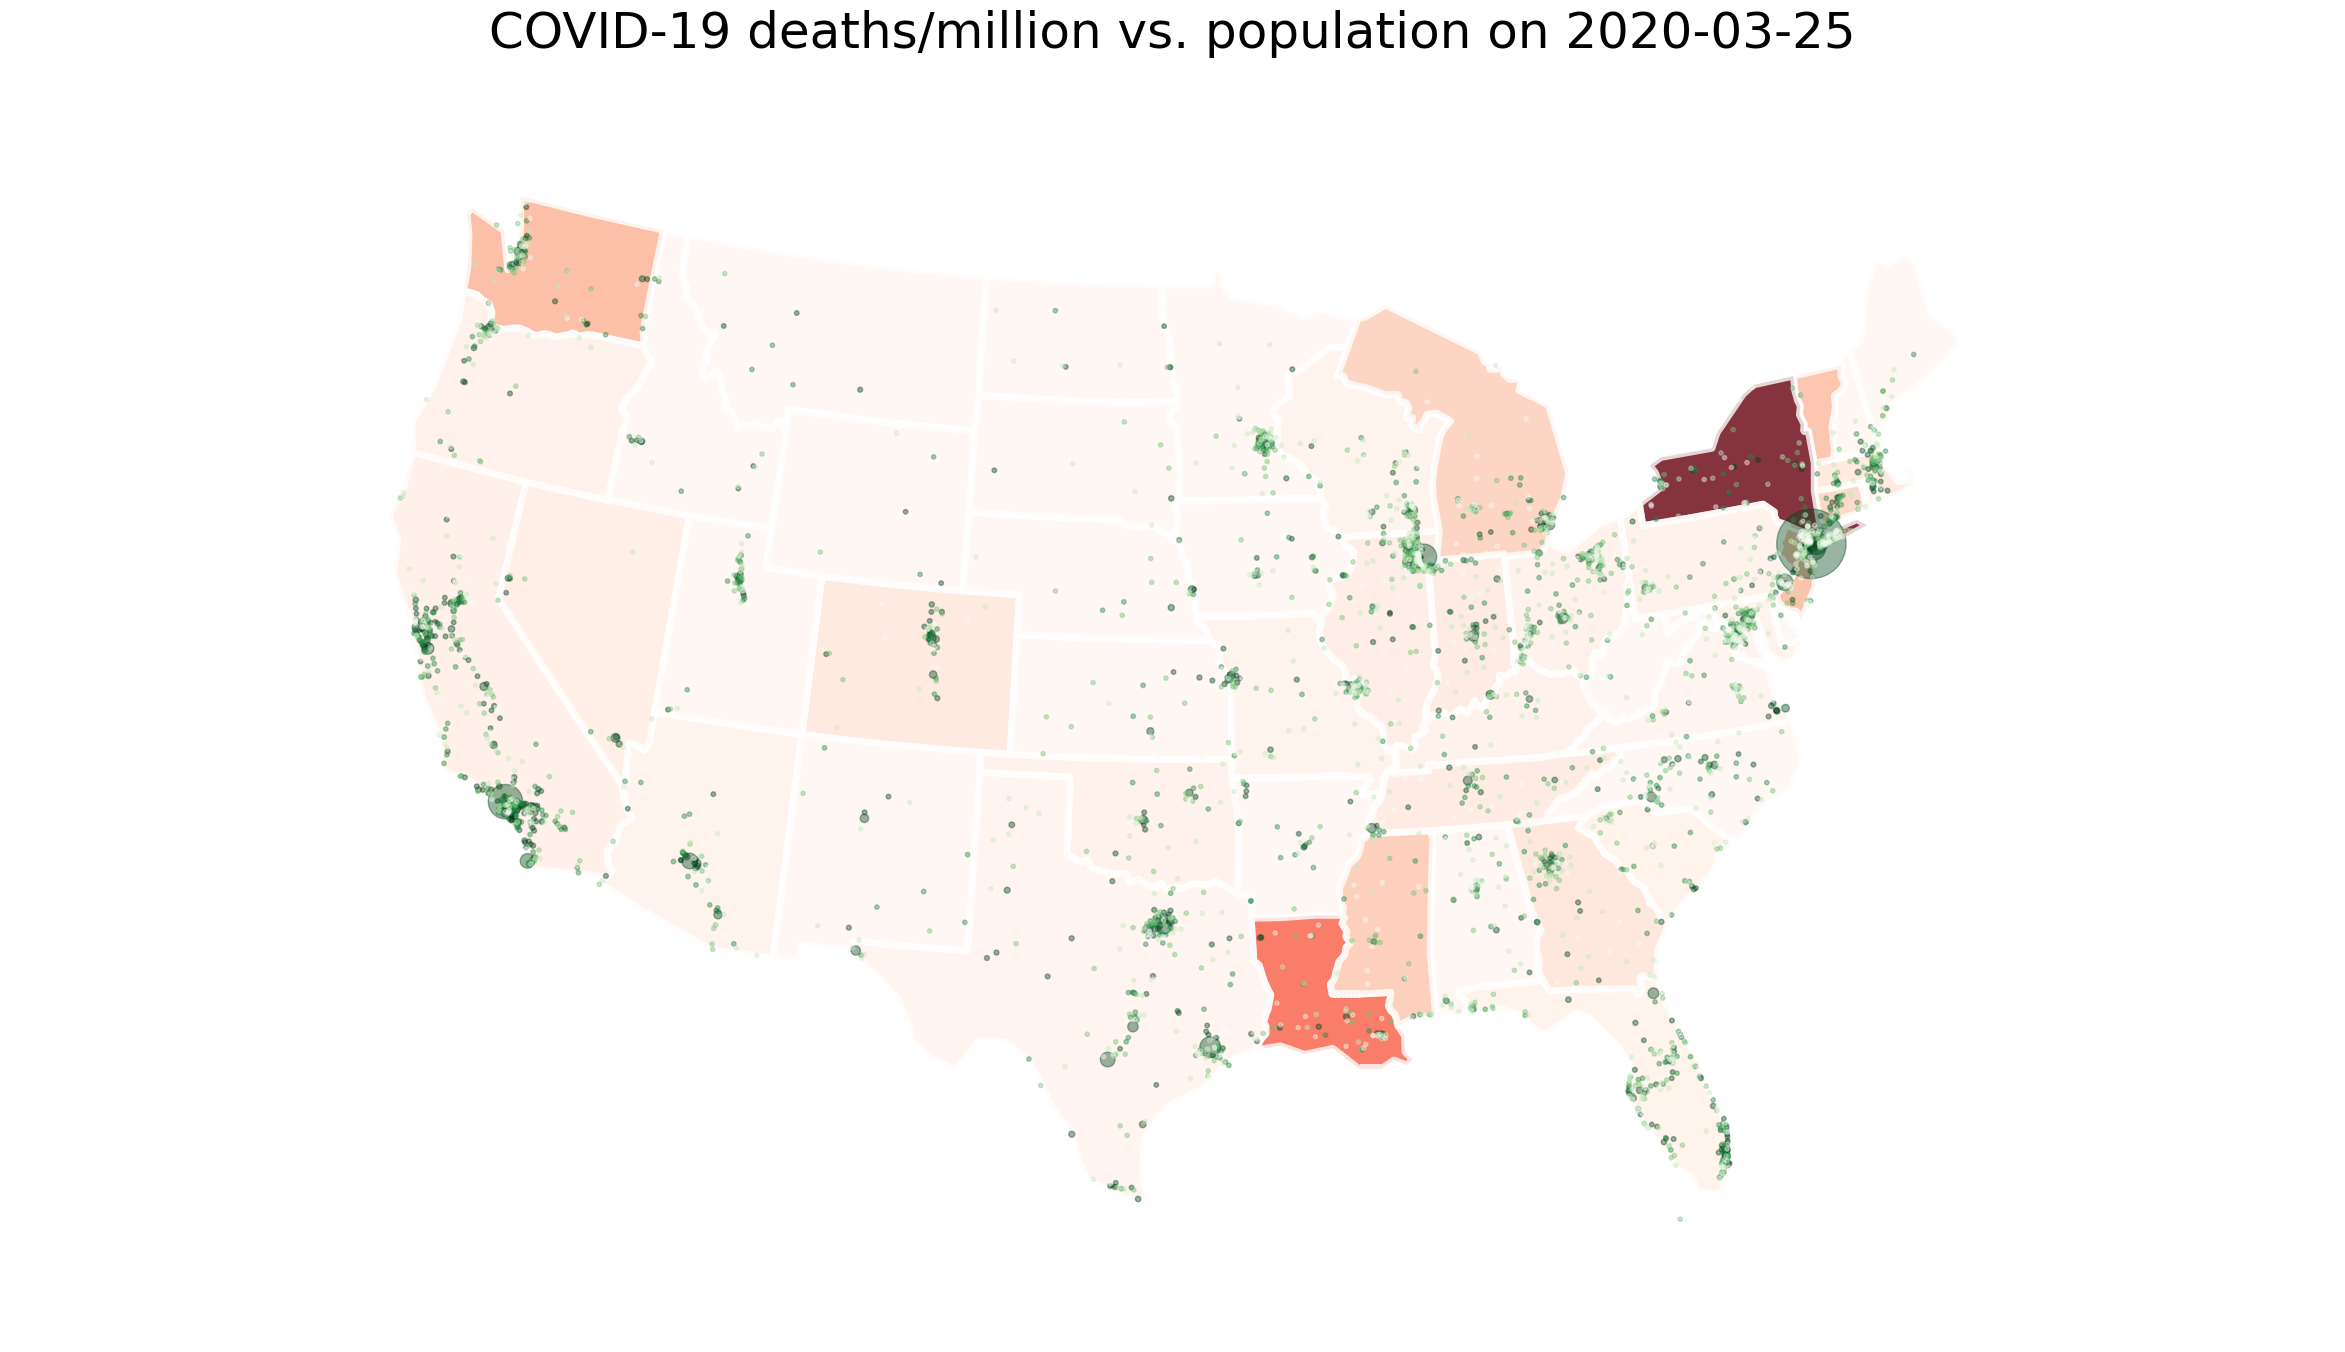

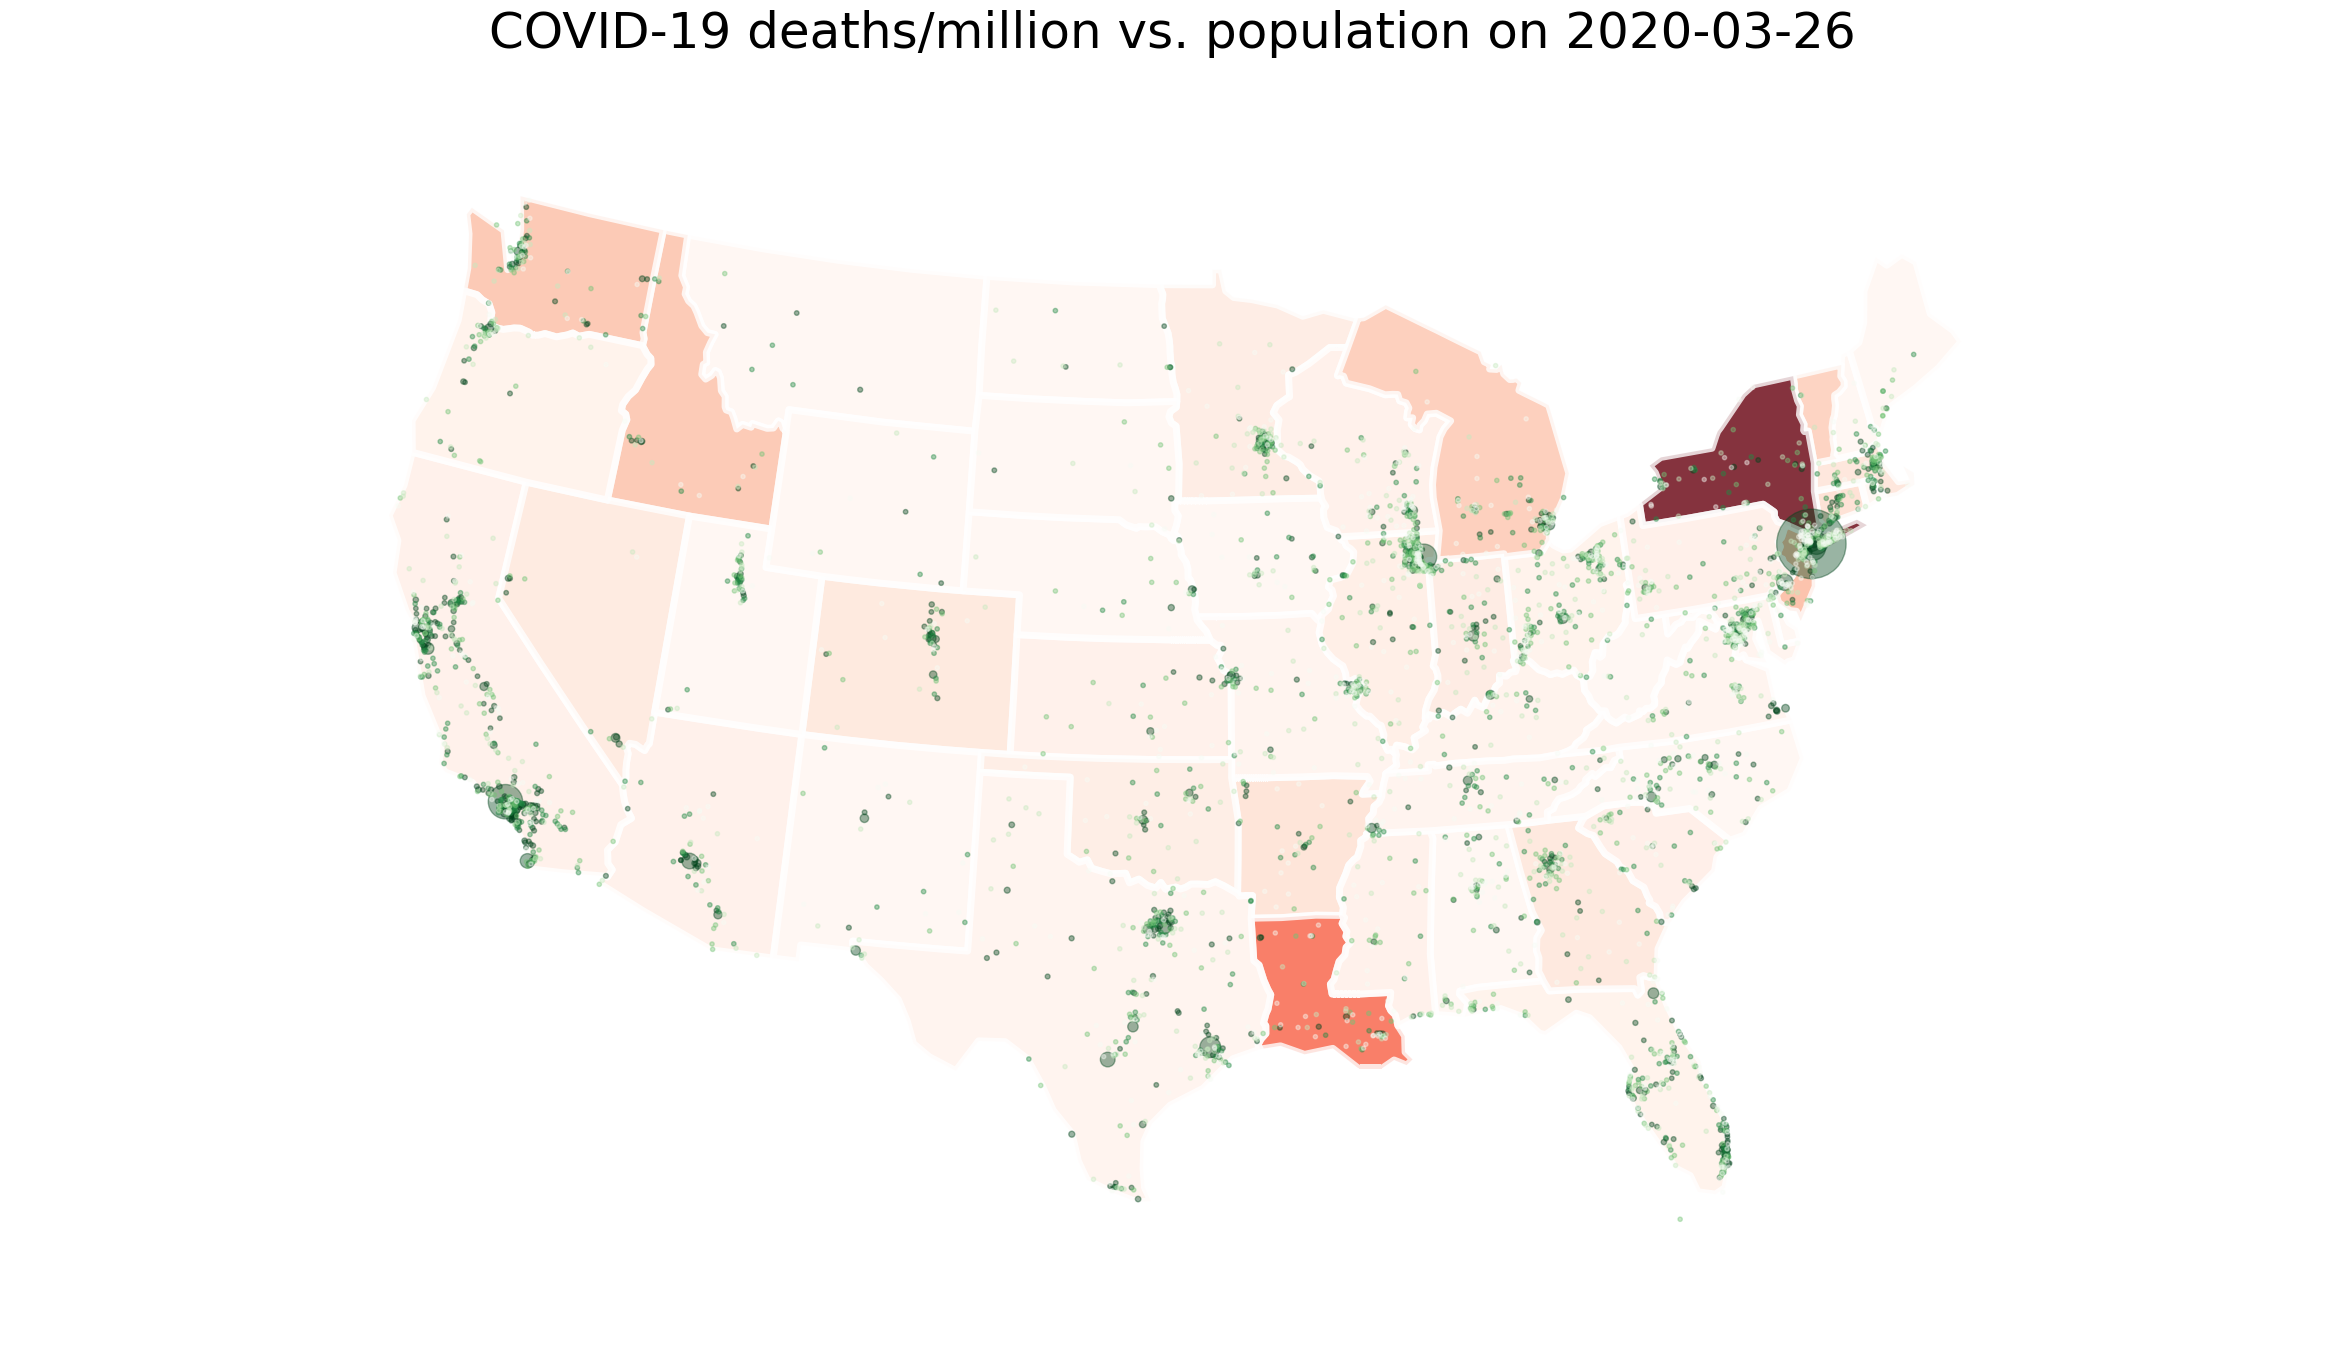

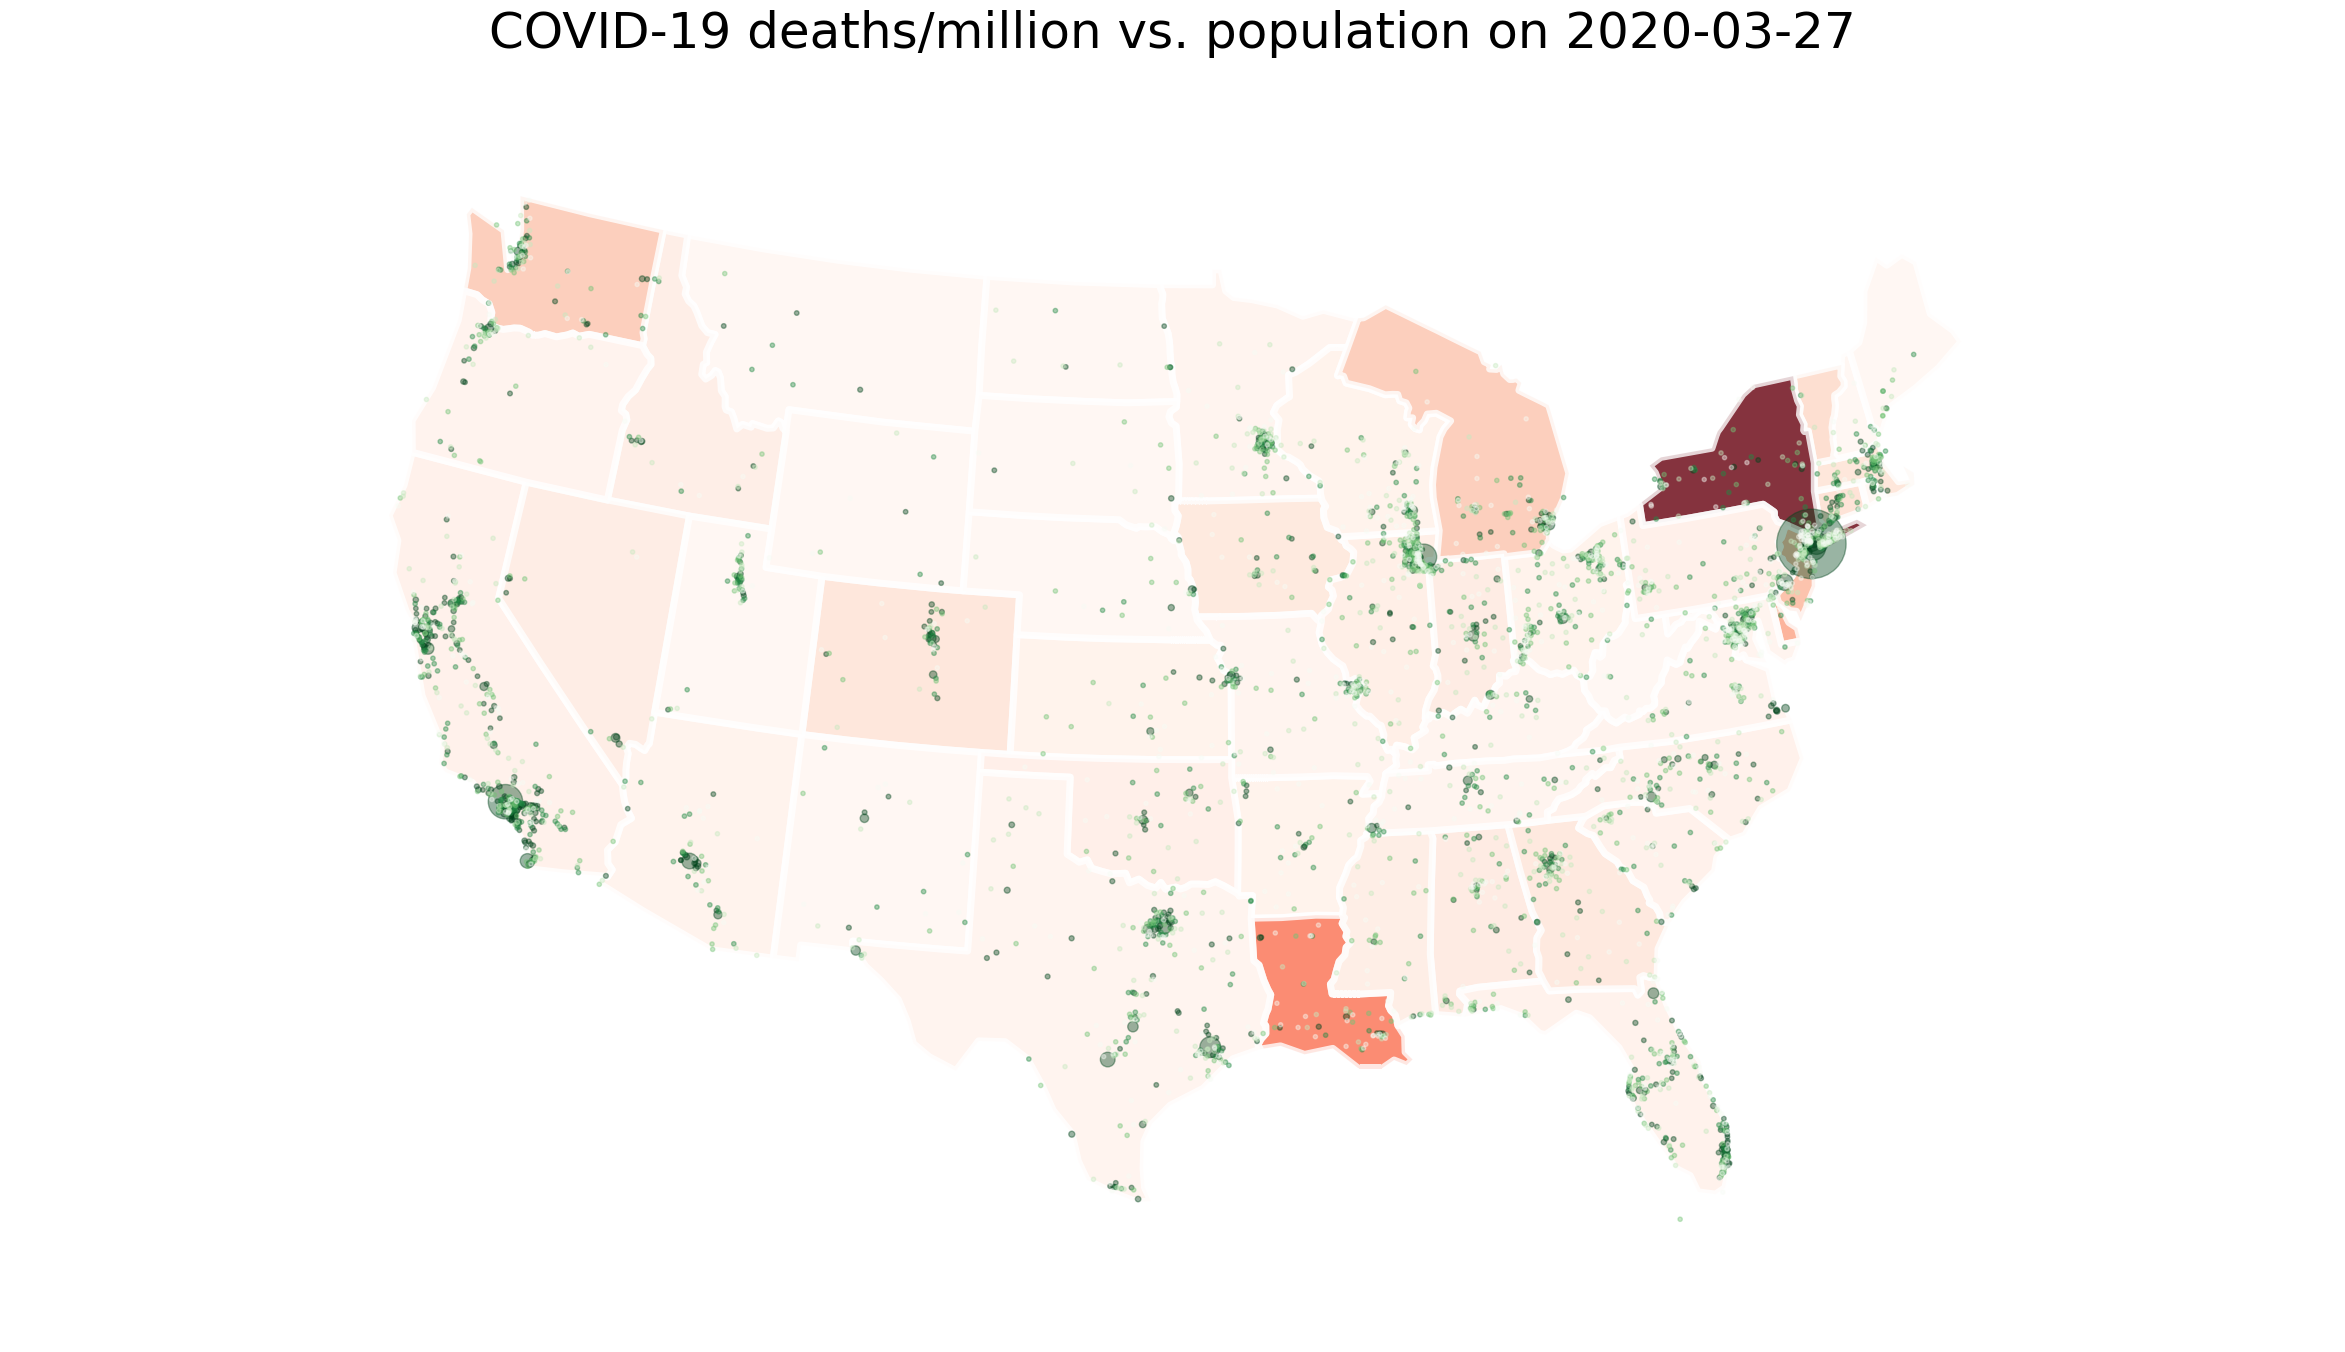

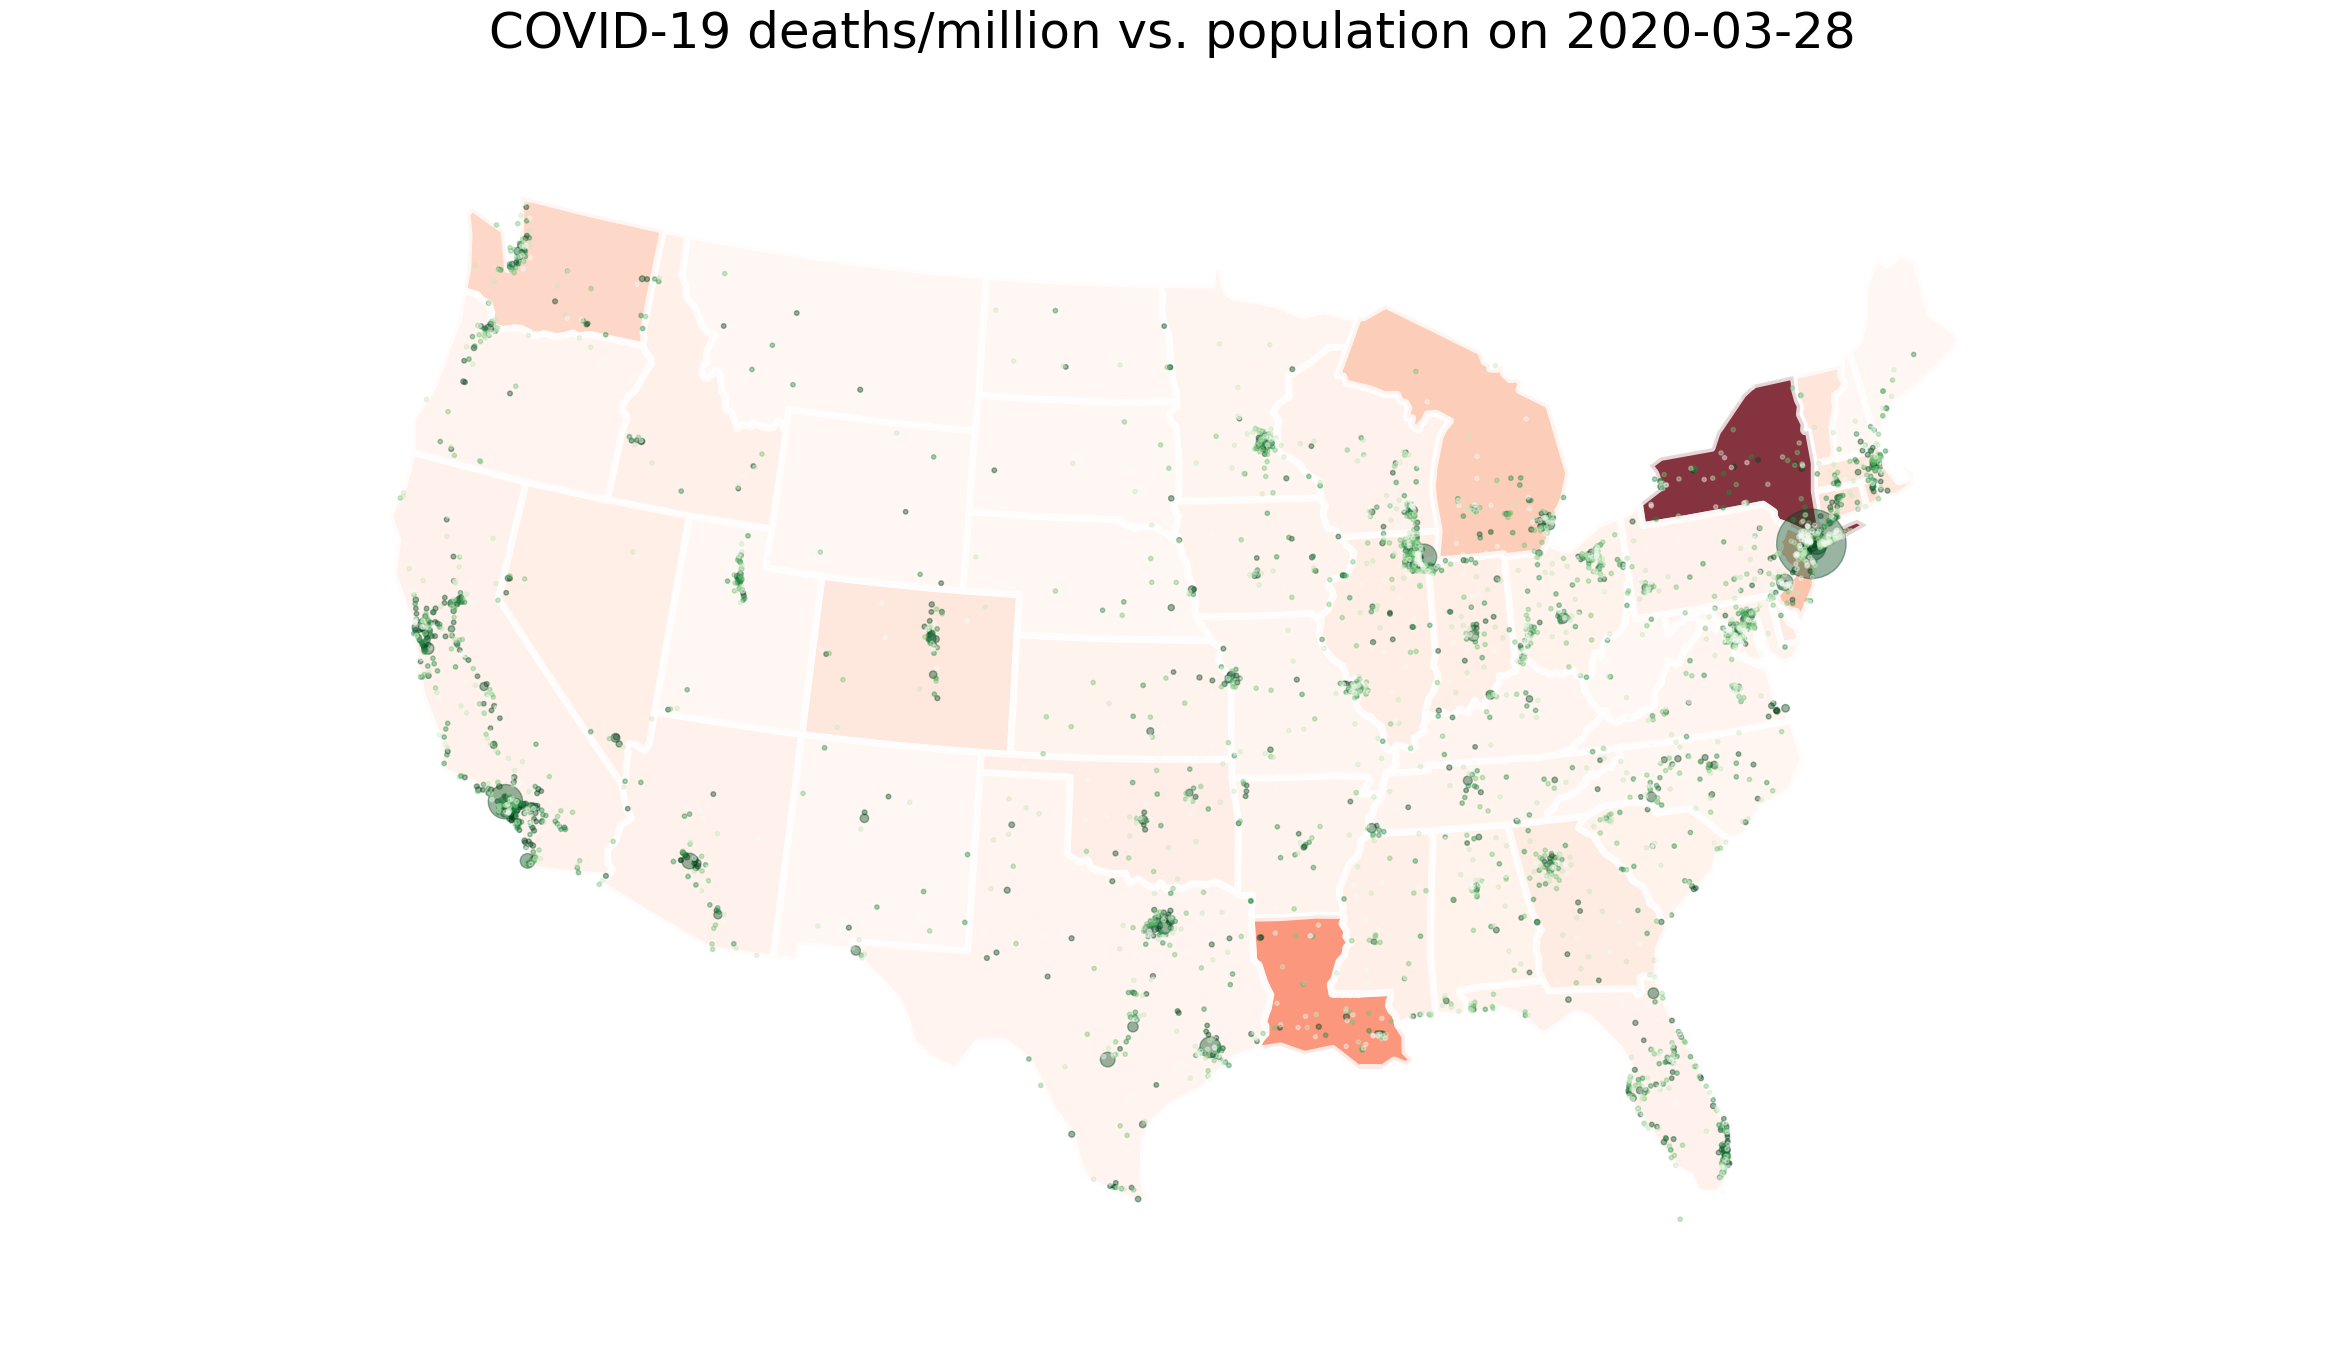

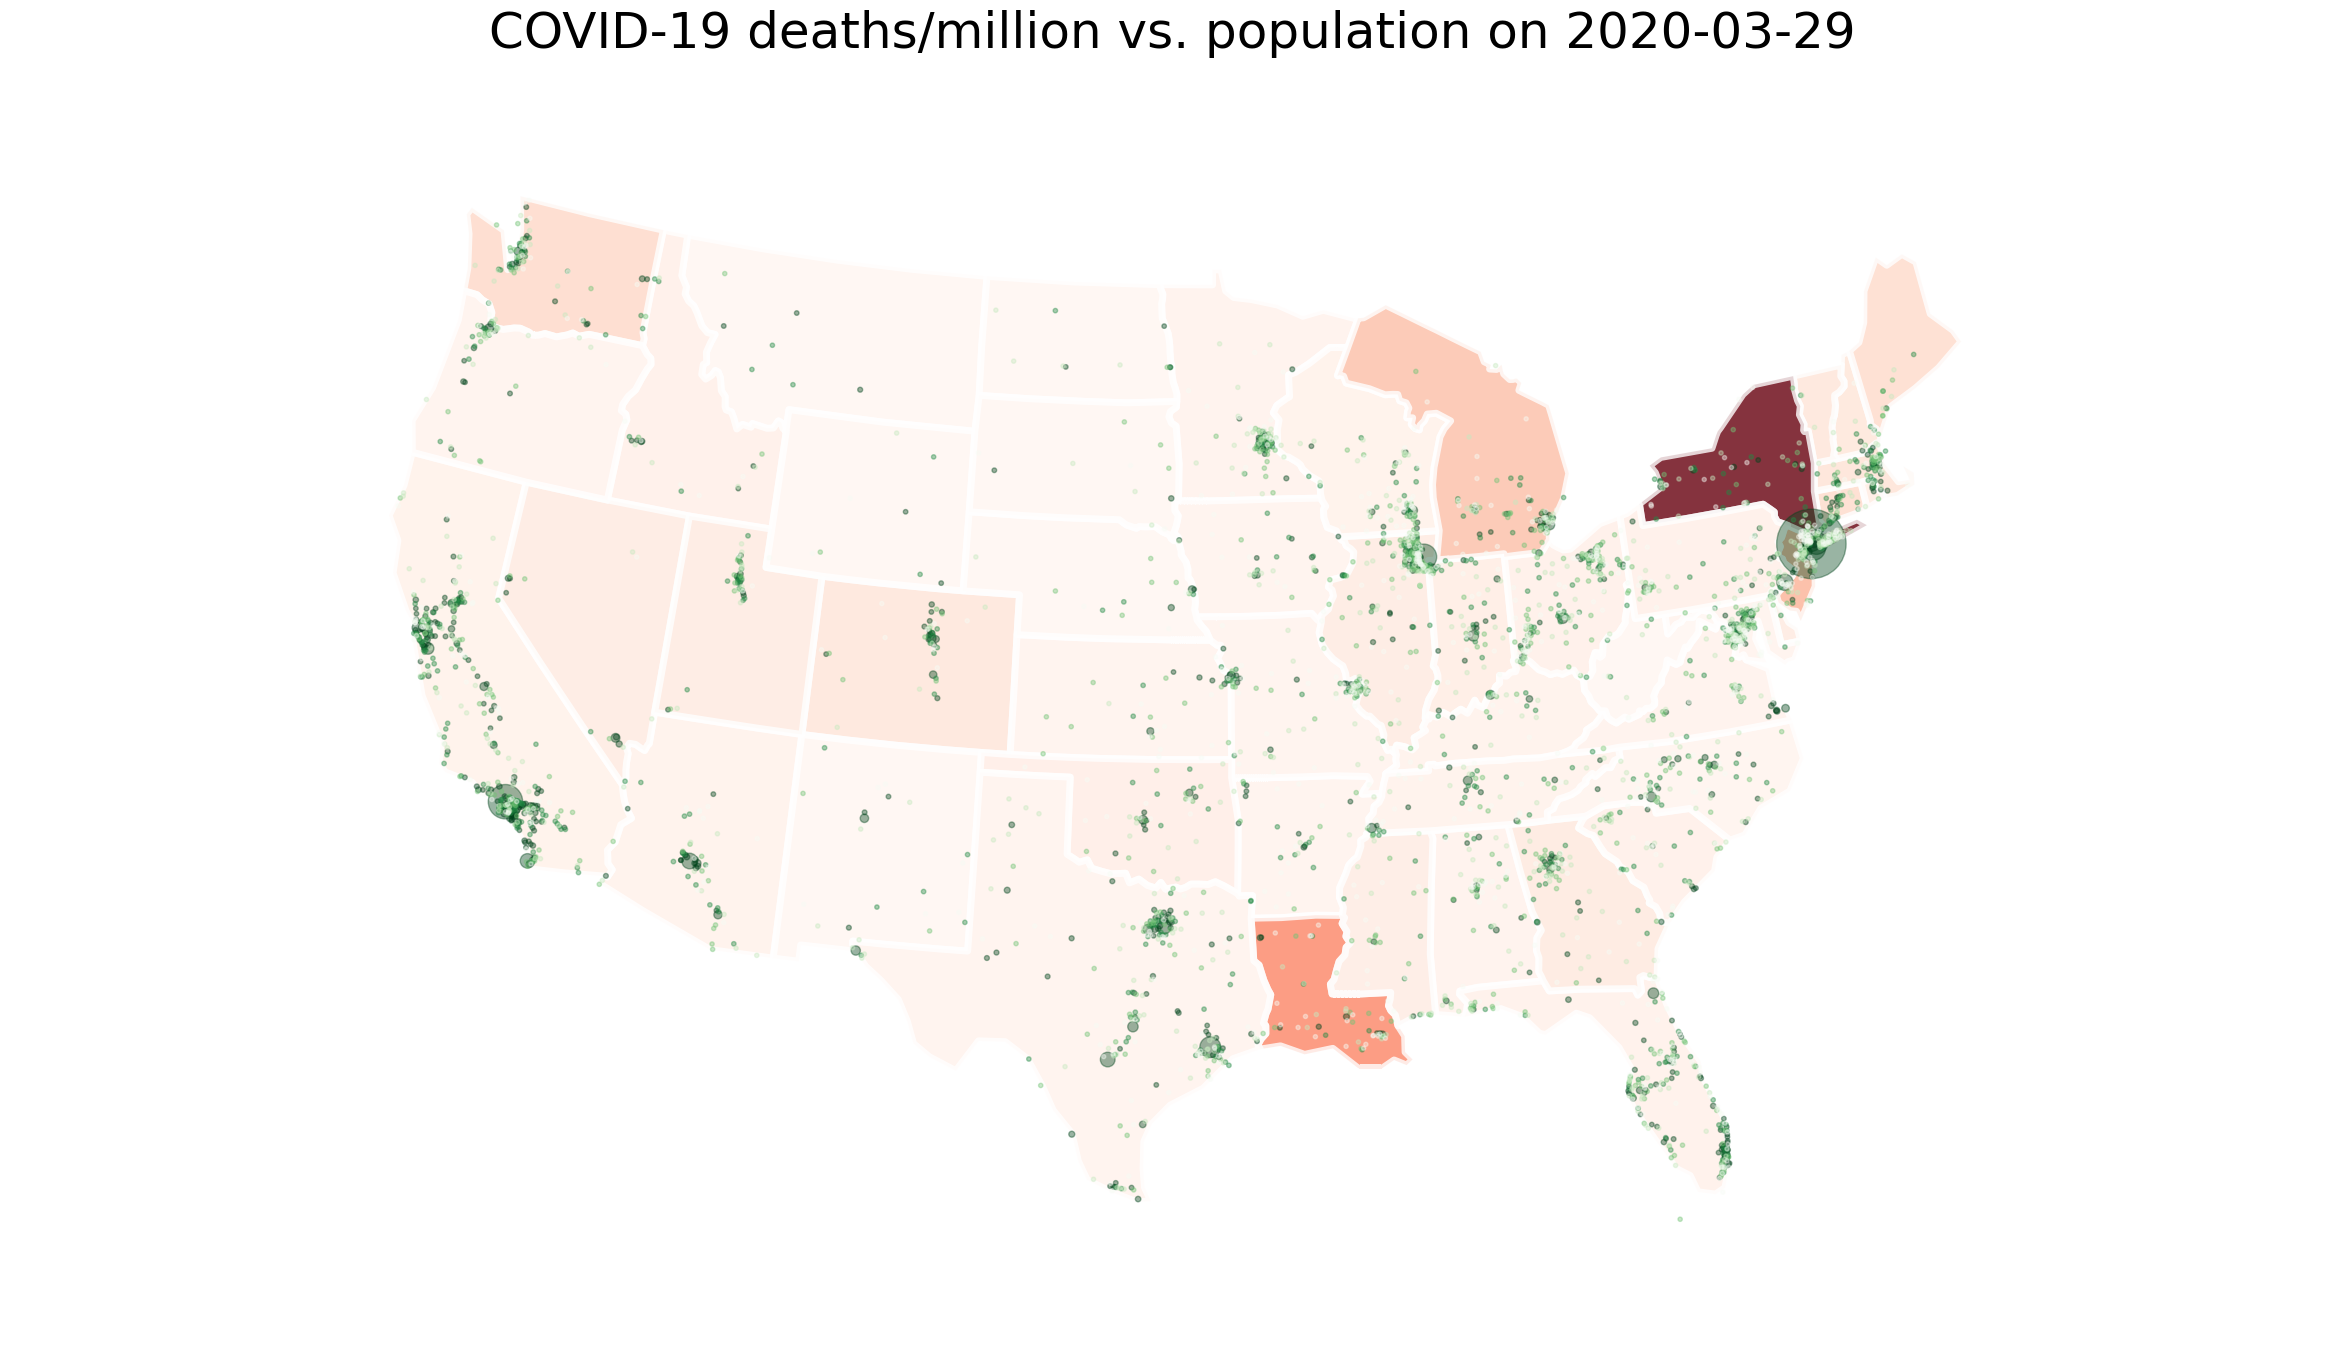

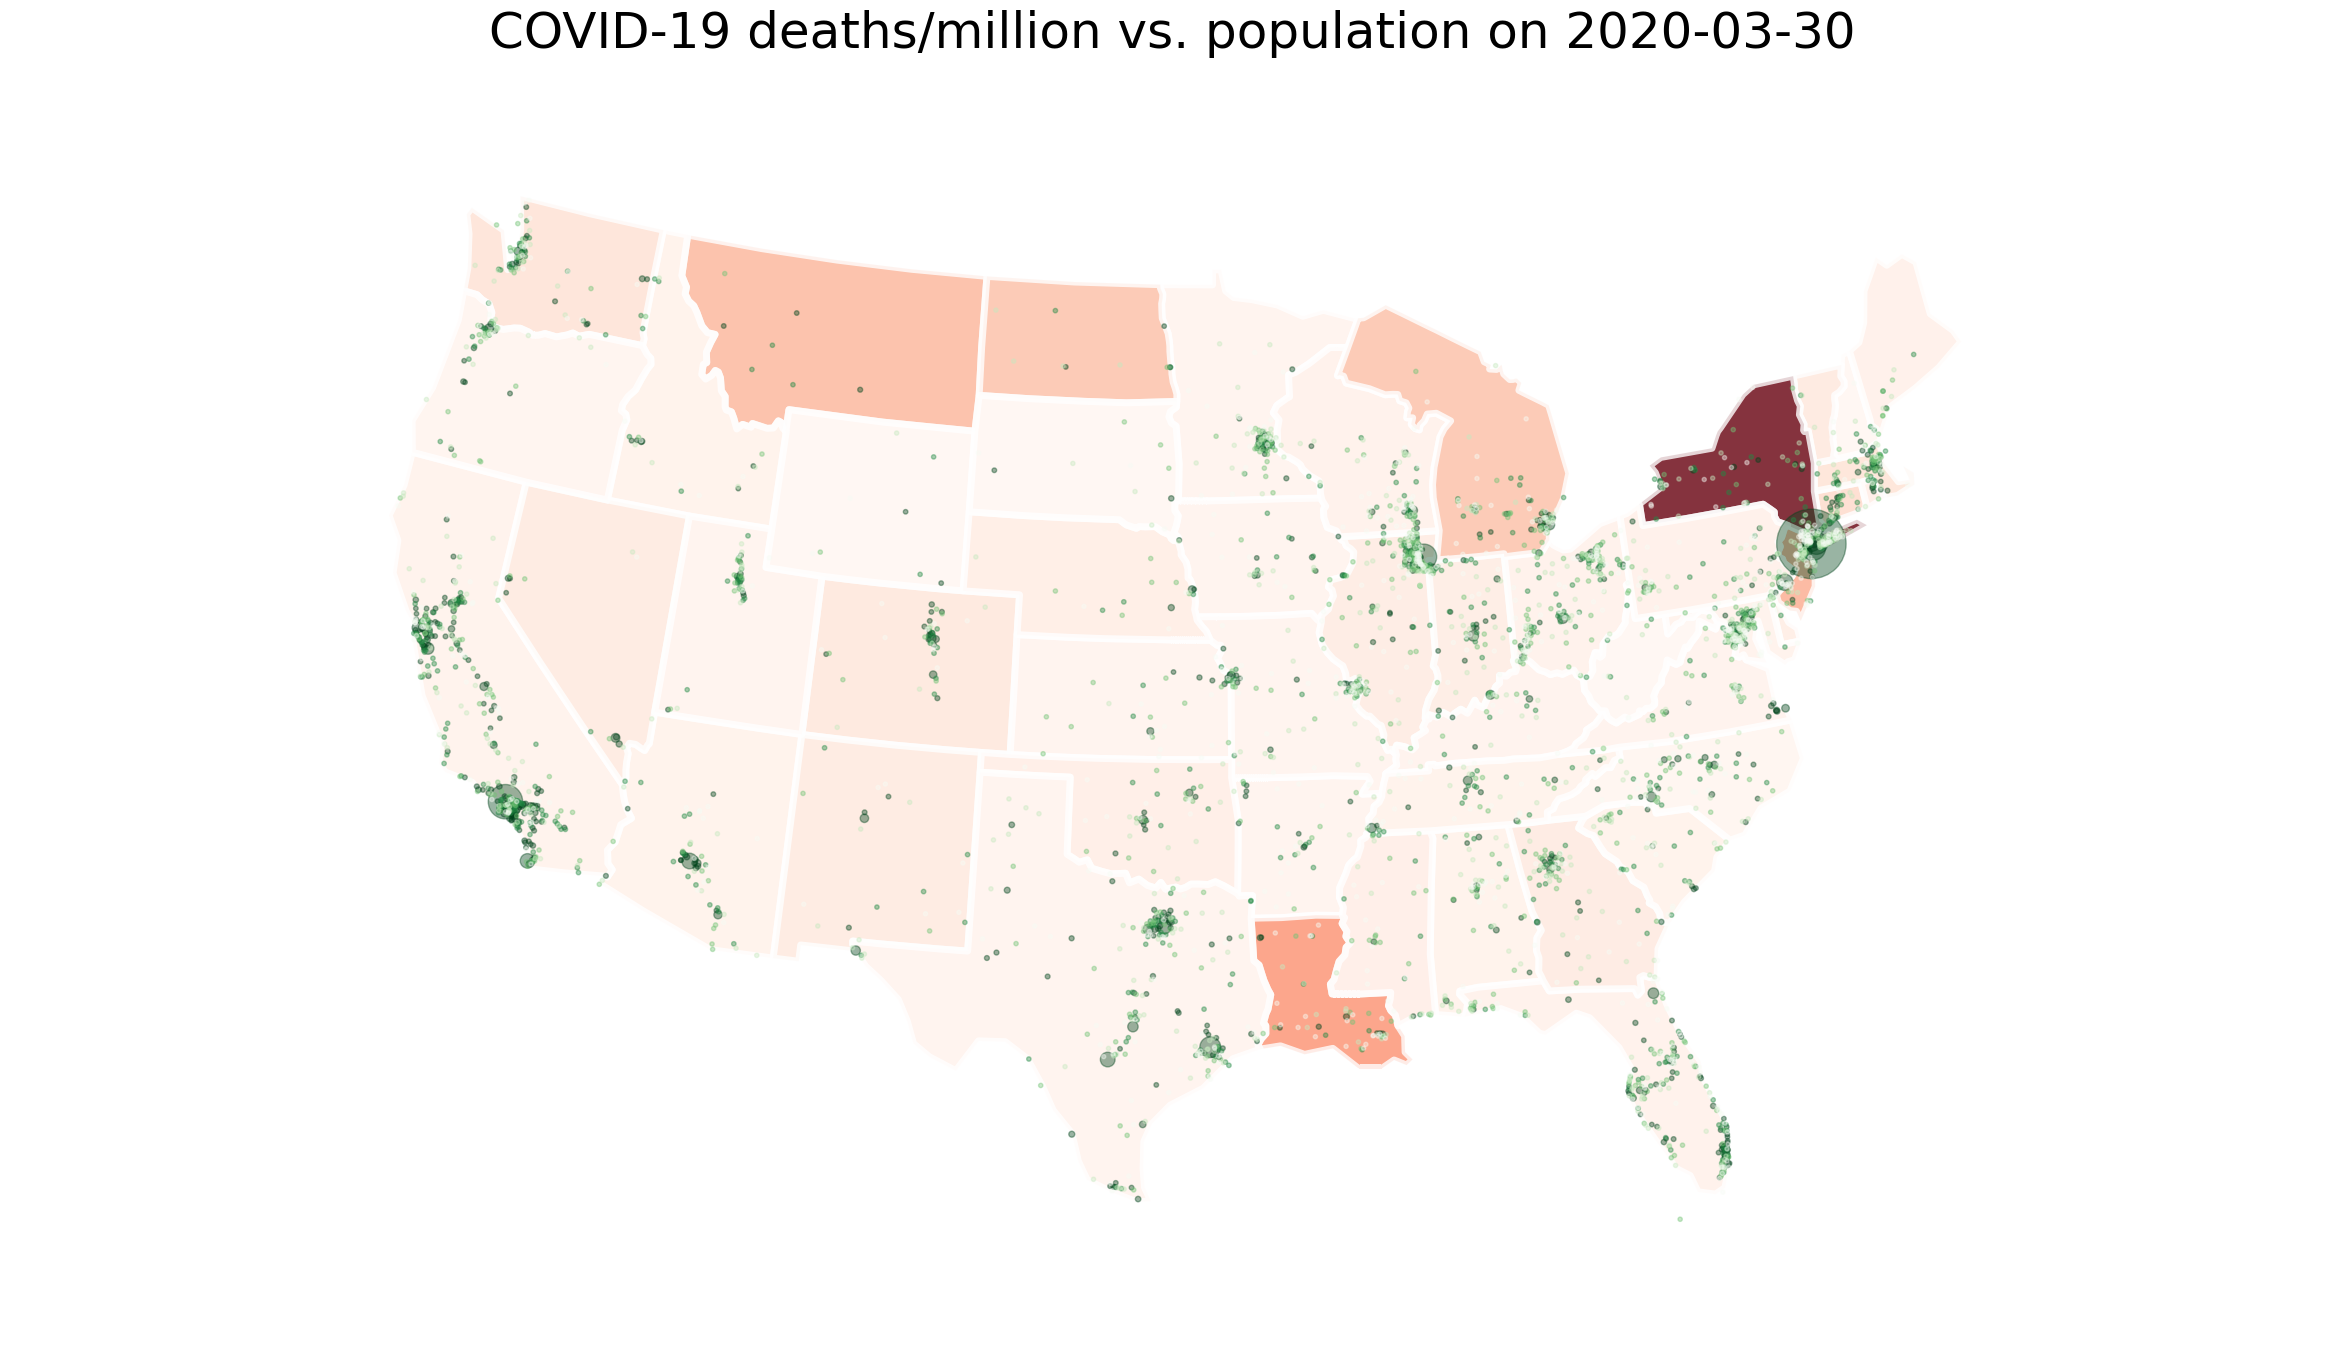

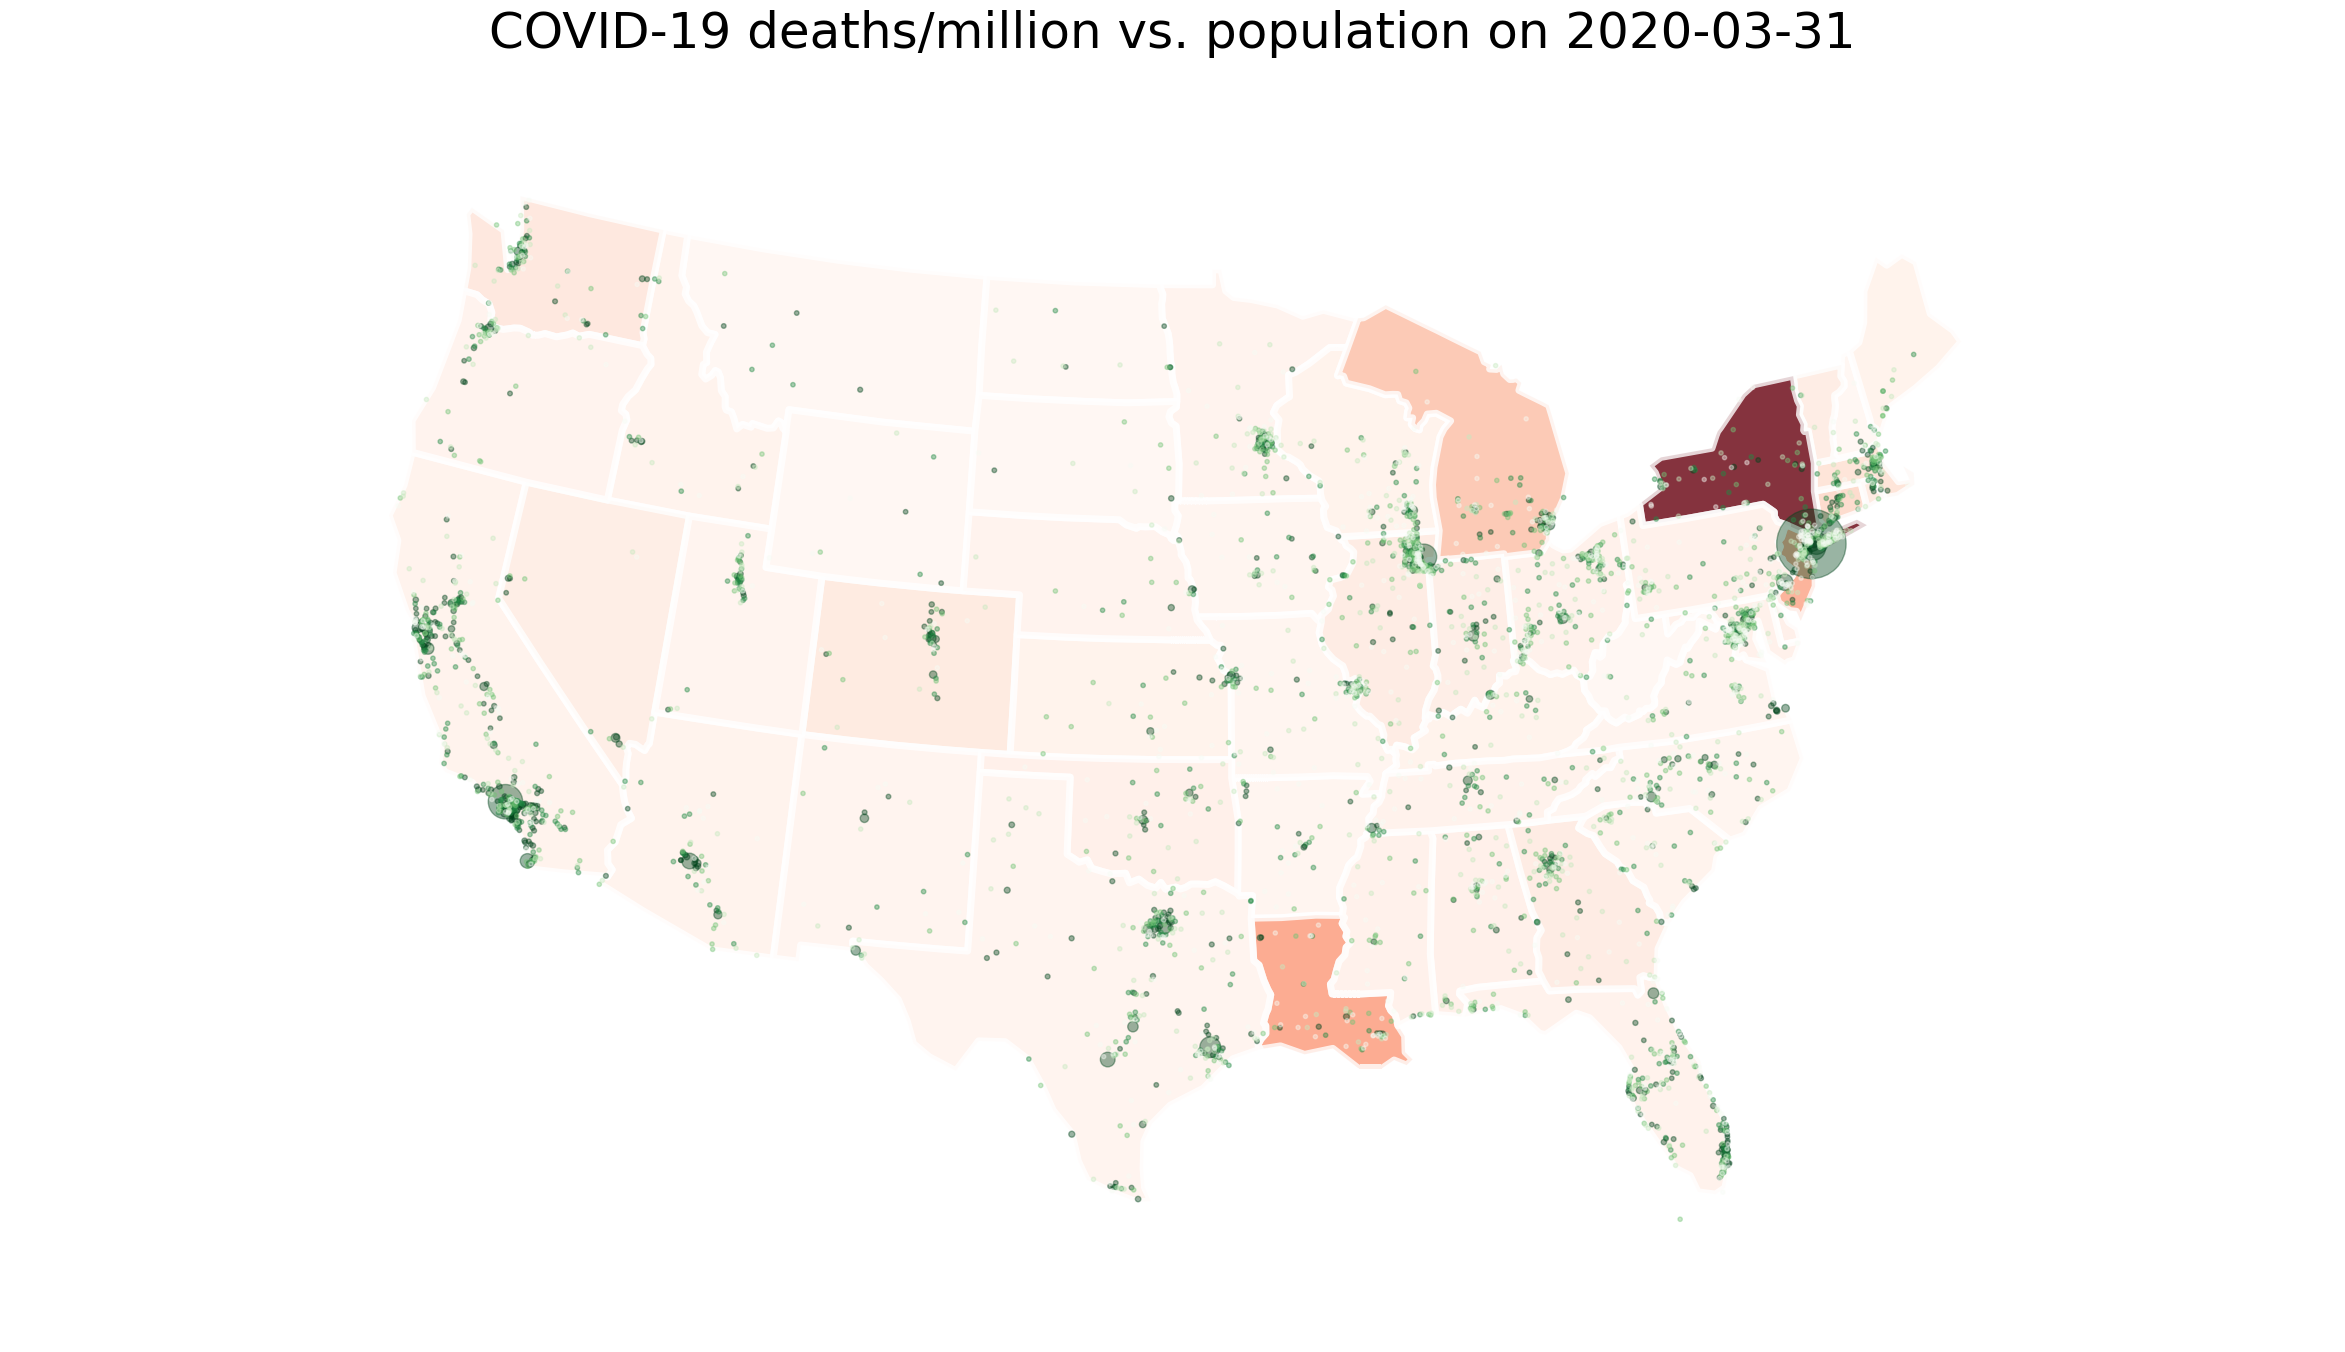

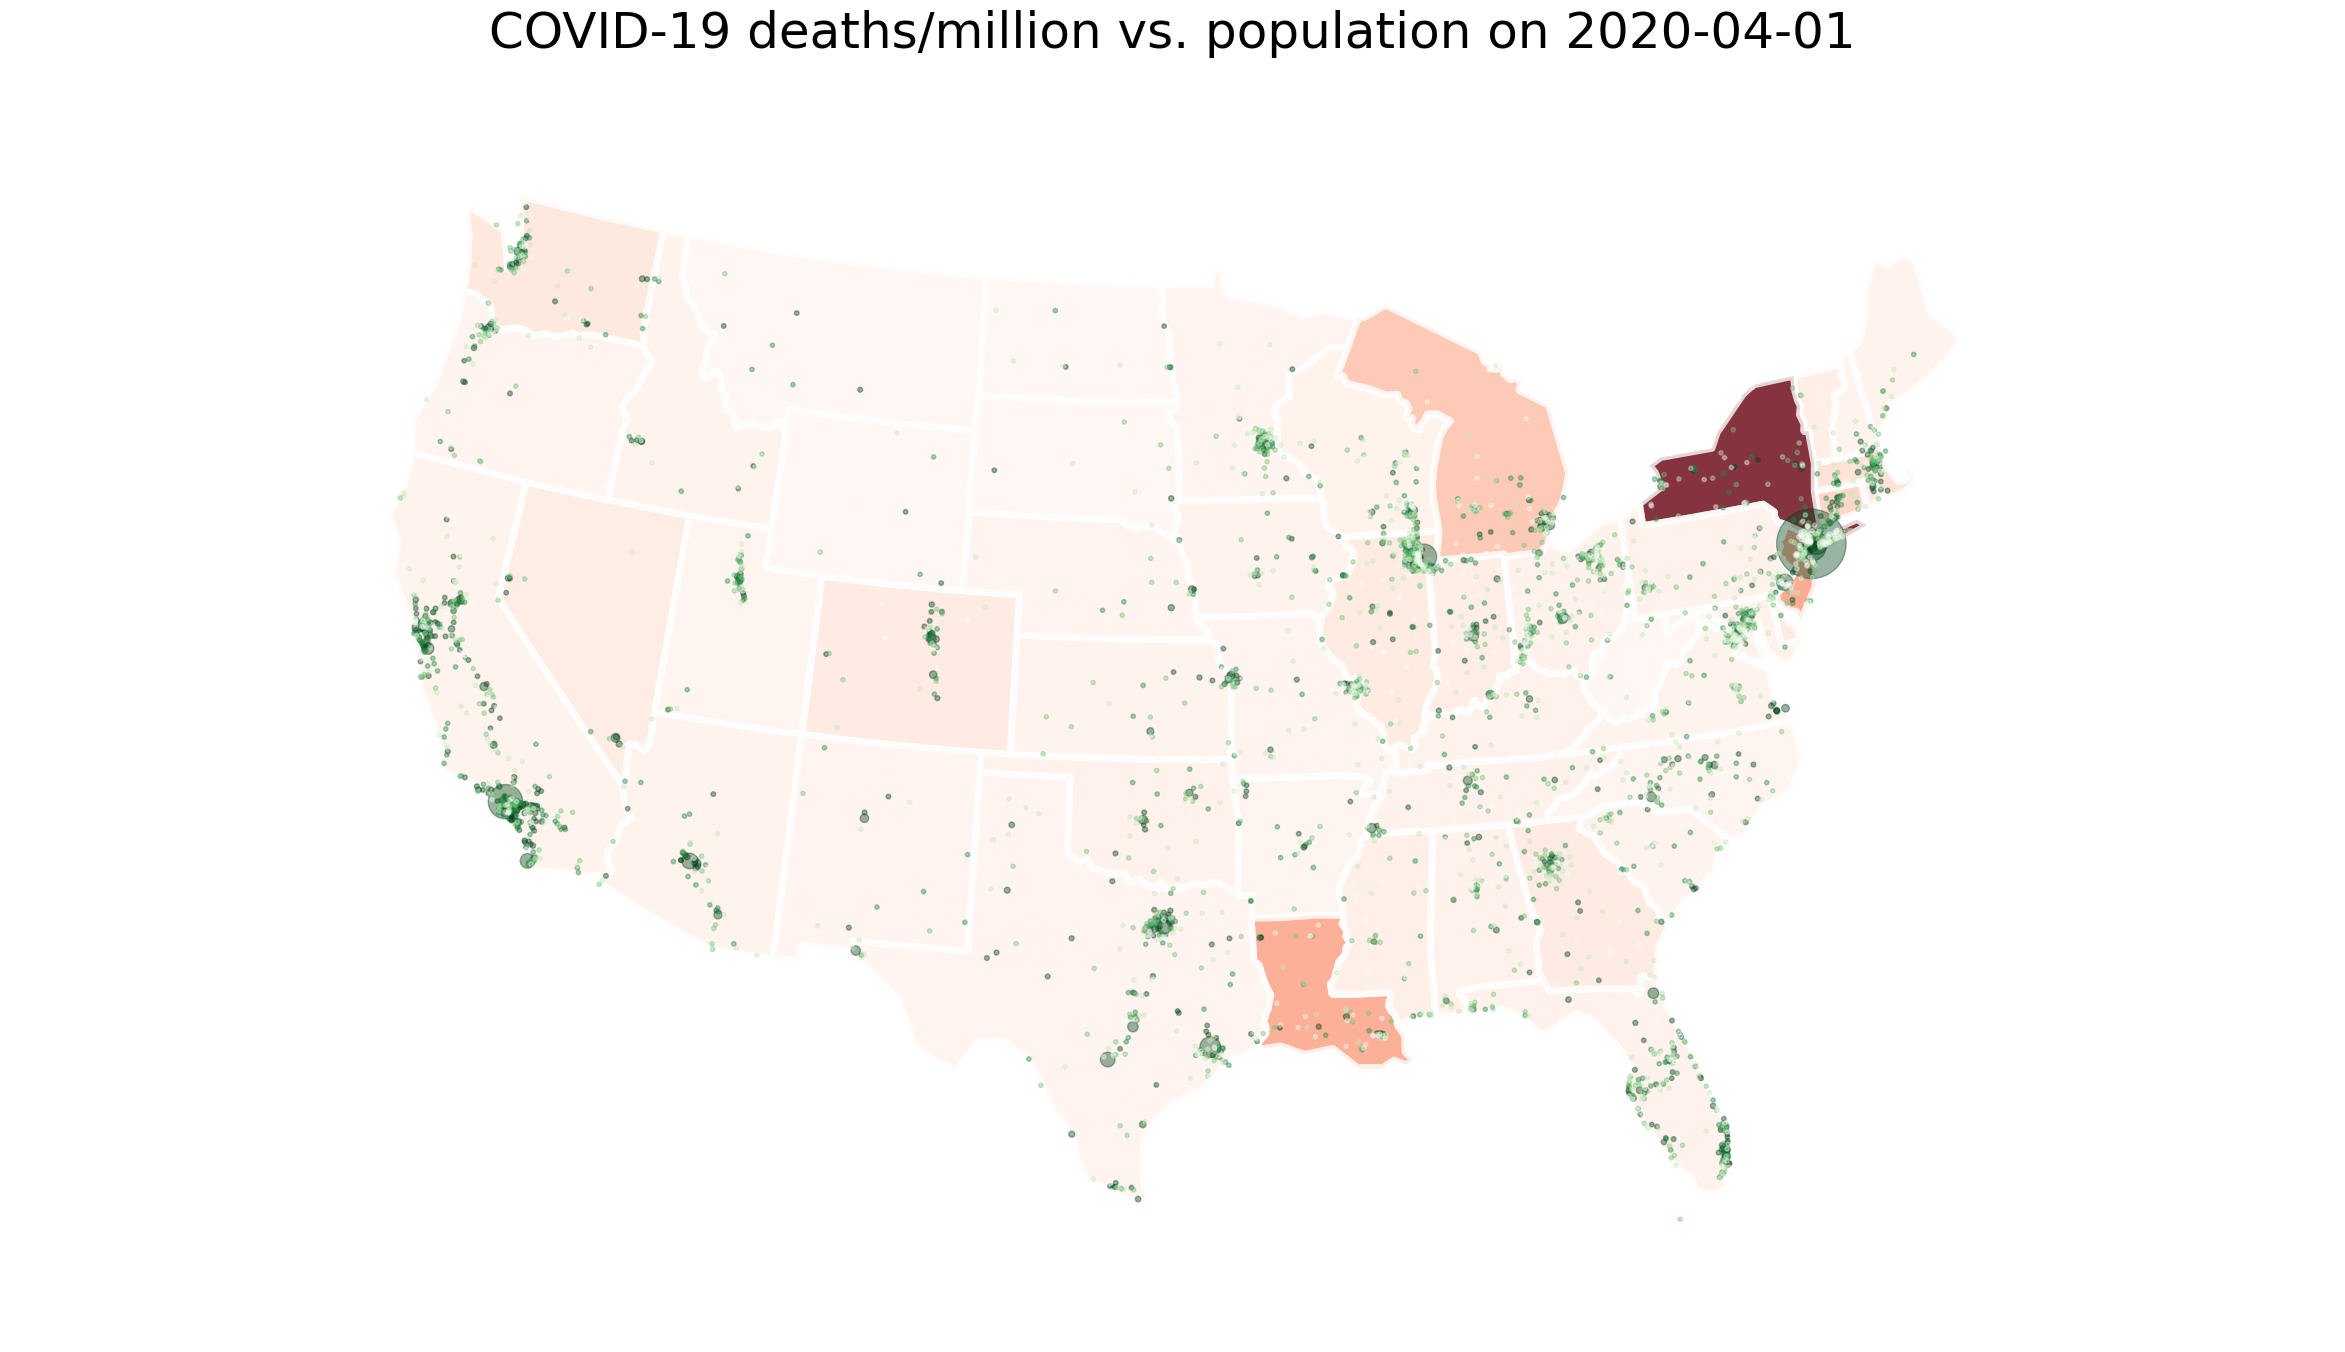

In [ ]:
anim_path = pathlib.Path("anim/")
anim_path.mkdir(parents=True, exist_ok=True)

fig = plt.figure()
image_files = []

for date in dates:
    is_earthday = ihme["date"]==date
    cv19 = contiguous_usa.merge(ihme[is_earthday], left_on="state", right_on="location_name")
    
    deaths_per_mil = cv19["deaths_mean"] / cv19["population"] * 1000000.0
    cv19["deaths_per_mil"] = deaths_per_mil

    file_name = plot_choropleth(anim_path, date, cv19, continental_usa_cities)
    image_files.append(file_name)

Use `imageio` to stitch these together into an animated GIF, at a rate of 2 frames/second:

In [ ]:
images = []

for file_name in image_files:
    images.append(imageio.imread(file_name))

gif_path = "movie.gif"
imageio.mimsave(gif_path, images, duration=20)

/tmp/ipykernel_6327/992471453.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_name))


Finally, let's show the animated GIF:

In [ ]:
from IPython.display import HTML

HTML('<img src="movie.gif" />')